## Train for Baseline Model (End - to - End)
### Load H5 file & Explore

In [1]:
# import required packages

import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import h5py
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from scipy.spatial.transform import Rotation as R
import pickle
from sklearn.preprocessing import StandardScaler

In [6]:
# ##### == In case of Trash Data has been found == #####

# file_path = os.path.expanduser("~/mpac_go2/build/data/20250321/143506_a1.h5")  # Latest data

# with h5py.File(file_path, 'r+') as f:
#     # data = np.array( f["common_timeseries"][:]['q'] )
#     data = f["common_timeseries"]
#     full_data = data[:]
#     # print(data.shape)

#     print("Before: ")
#     print(full_data[96919]['q'][0:2])
#     print(full_data[514470]['q'][0:2])

#     full_data[96919]['q'][0:2] = full_data[96919 + 1]['q'][0:2]
#     full_data[514470]['q'][0:2] = full_data[514470 + 1]['q'][0:2]

#     print("After: ")
#     print(full_data[96919]['q'][0:2])
#     print(full_data[514470]['q'][0:2])

#     del f["common_timeseries"]
#     f.create_dataset( "common_timeseries", data=full_data)


# print("\nRead again")
# # Read again
# with h5py.File(file_path, 'r') as f:
#     # data = np.array( f["common_timeseries"][:]['q'] )
#     data = f["common_timeseries"][:]['q']
#     # print(data.shape)

#     print("Before: ")
#     print(data[96919, 0:2])
#     print(data[514470, 0:2])

In [2]:
def explore_h5_file(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Group):
                print(f"Group: {name}")
            elif isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")

        print("HDF5 File Structure:")
        h5_file.visititems(print_structure)

# file_path = os.path.expanduser("~/mpac_go2/build/data/latest.h5")  # Latest data

file_path = os.path.expanduser("~/mpac_go2/build/data/20250322/155701_a1.h5")  # Validation
explore_h5_file(file_path)

HDF5 File Structure:
Dataset: bound_attributes, Shape: (0,), Dtype: |S1
Dataset: bound_timeseries, Shape: (0,), Dtype: |S1
Dataset: calibrate_attributes, Shape: (0,), Dtype: |S1
Dataset: calibrate_timeseries, Shape: (0,), Dtype: |S1
Dataset: common_attributes, Shape: (1,), Dtype: {'names': ['epoch_time', 'cycle_duration', 'compute_duration', 'tictoc', 'path_compute_duration', 'q', 'qd', 'u', 'act_mode', 'q_des', 'qd_des', 'u_des', 'f', 'temp'], 'formats': [[('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f8'), ('warn_hi', '<f8'), ('crit_hi', '<f8')], [('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f8'), ('warn_hi', '<f8'), ('crit_hi', '<f8')], [('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f8'), ('warn_hi', '<f8'), ('crit_hi', '<f8')], [('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f8'), ('warn_hi', '<f8'), ('crit_hi', '<f8')], [('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f

### Extract desired data

In [4]:
with h5py.File(file_path, 'r') as f:
    dataset = np.array( f["common_timeseries"] )  # Data as numpy array

N_t = dataset.shape[0]  # Total timesteps
print( "Total number of timesteps of Dataset:" )
print( N_t )

print( "\nData type of Dataset:" )
print( dataset.dtype )  # Data types

# 1. Timestamps
time = dataset[:]['epoch_time']
time = np.round( time - time[0] , 4) # Shift - make starting time as 0

# 2. q
q = dataset[:]['q'] # Joint position variable
dim = q[0].shape[0] # Dimension of q
print("\nDimension of Variable (q):")
print(dim)
# Data meanings
"""
X_global: Global position of robot's body - X
Y_global: Global position of robot's body - Y
Z_global: Global position of robot's body - Z
Rx: Euler angle to express body posture - X
Ry: Euler angle to express body posture - Y
Rz: Euler angle to express body posture - Z
Q: Joint Positions - 12 dim. in total (3 for eag leg, 4 legs)
"""
q_name = np.array(["X_global", "Y_global", "Z_global", "Rx", "Ry", "Rz", "Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
qd_name = np.array(["X_global_dot", "Y_global_dot", "Z_global_dot", "Rx_dot", "Ry_dot", "Rz_dot", "Q_FL1_dot", "Q_FL2_dot", "Q_FL3_dot", "Q_FR1_dot", "Q_FR2_dot", "Q_FR3_dot", "Q_RL1_dot", "Q_RL2_dot", "Q_RL3_dot", "Q_RR1_dot", "Q_RR2_dot", "Q_RR3_dot"])


# 3. qd
qd = dataset[:]['qd'] # Joint velocity variable 

Total number of timesteps of Dataset:
180040

Data type of Dataset:
{'names': ['local_date', 'local_time', 'epoch_time', 'cycle_count', 'cycle_duration', 'compute_duration', 'tictoc', 'path_compute_duration', 'q', 'qd', 'u', 'temp', 'act_mode', 'q_des', 'qd_des', 'u_des'], 'formats': ['S32', 'S32', '<f16', '<u8', '<f8', '<f8', '<f8', '<f8', ('<f8', (18,)), ('<f8', (18,)), ('<f8', (12,)), ('<f8', (12,)), ('<i4', (12,)), ('<f8', (12,)), ('<f8', (12,)), ('<f8', (12,))], 'offsets': [3280, 3312, 3264, 16, 24, 32, 40, 48, 56, 200, 488, 952, 584, 728, 824, 632], 'itemsize': 4768}

Dimension of Variable (q):
18


### Explore

/tmp/ipykernel_187566/1018304832.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure( figsize=[24, 6] )


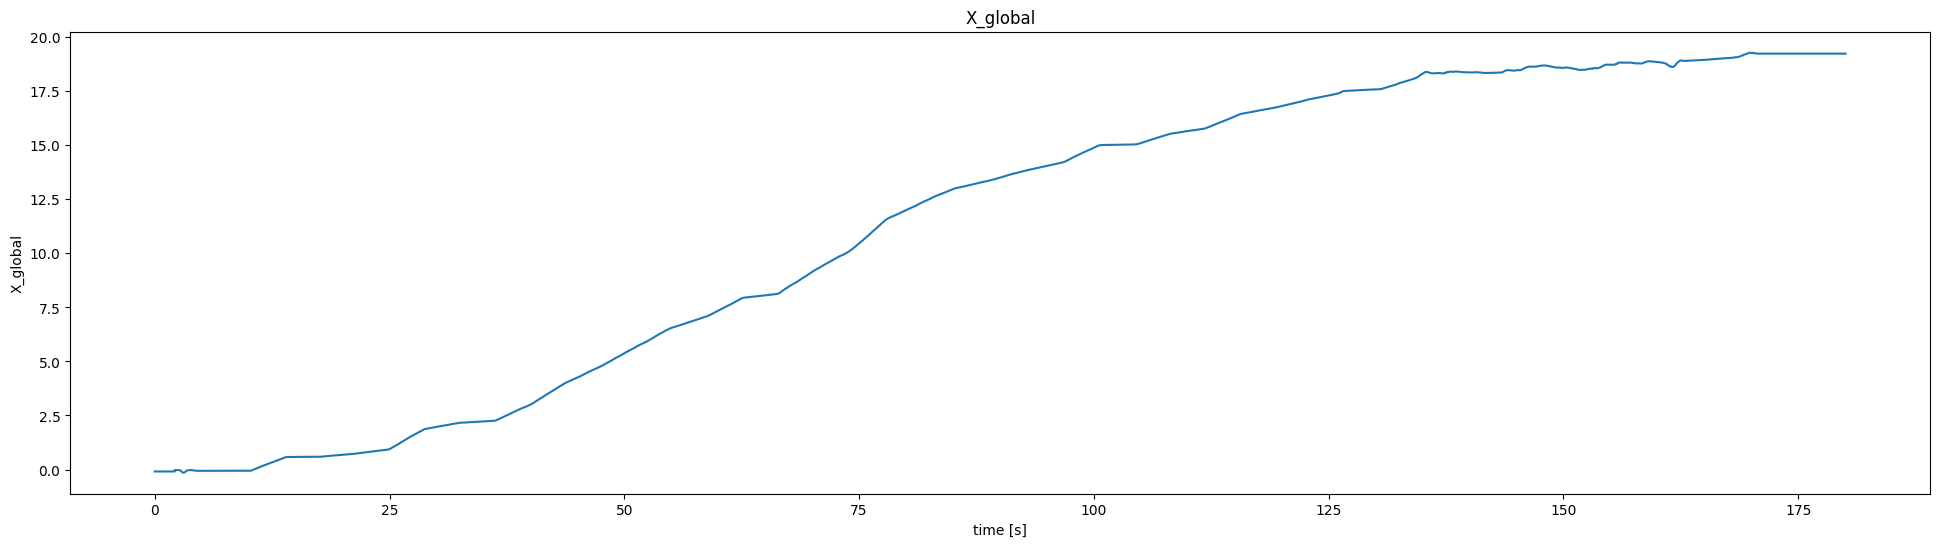

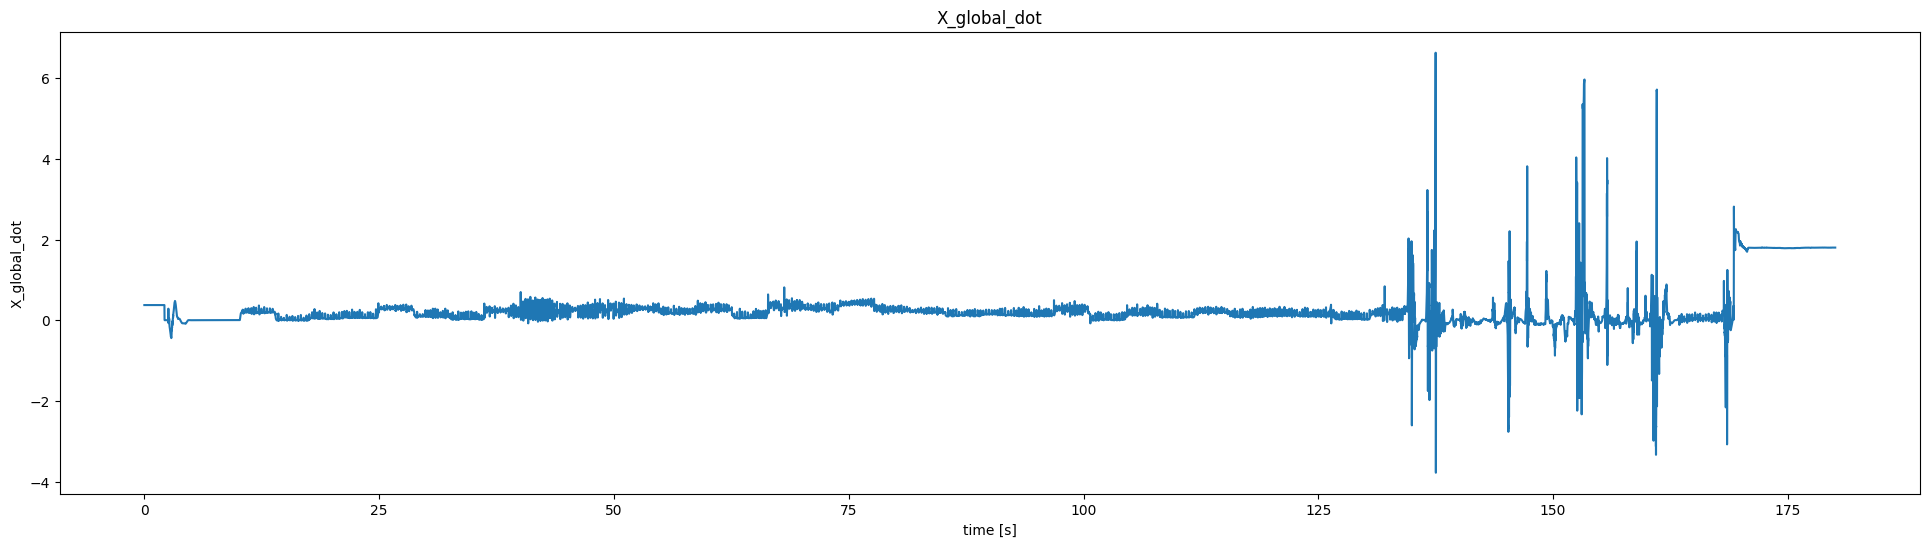

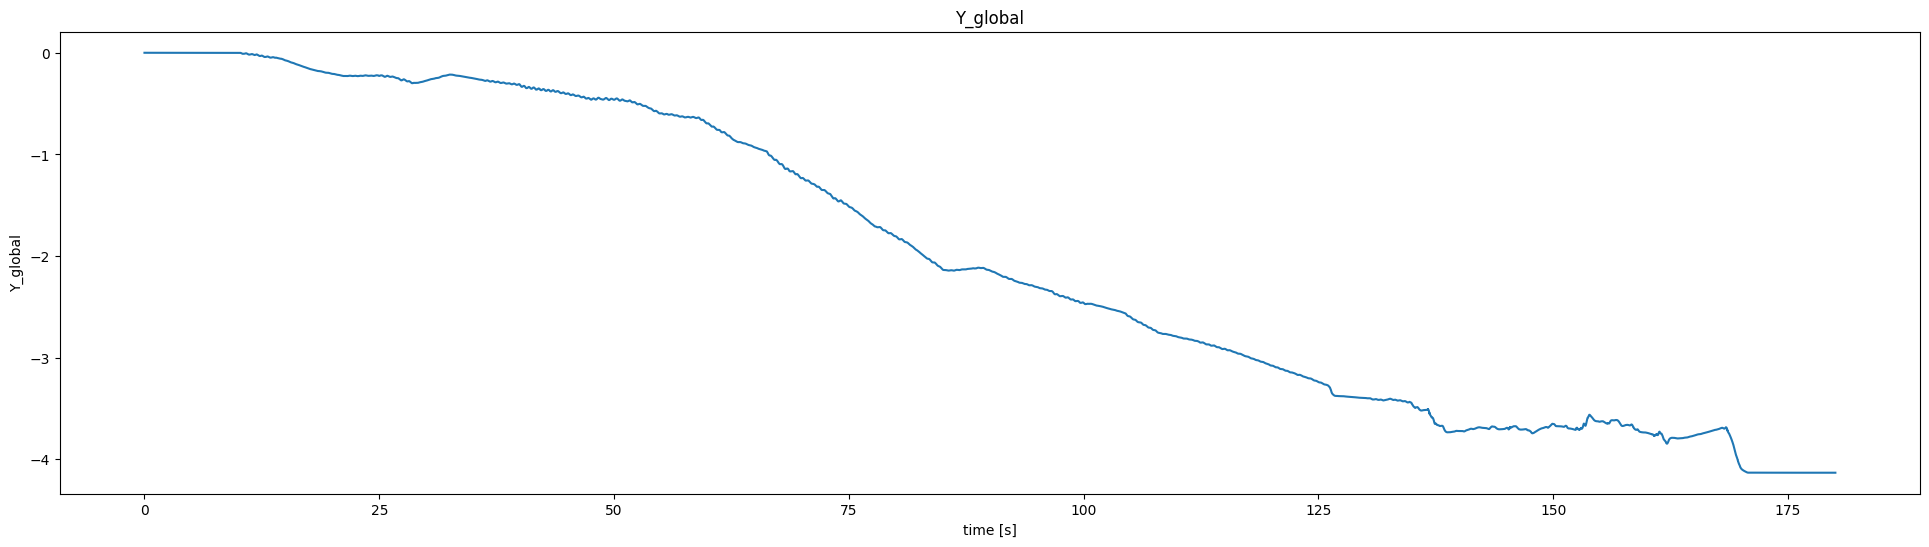

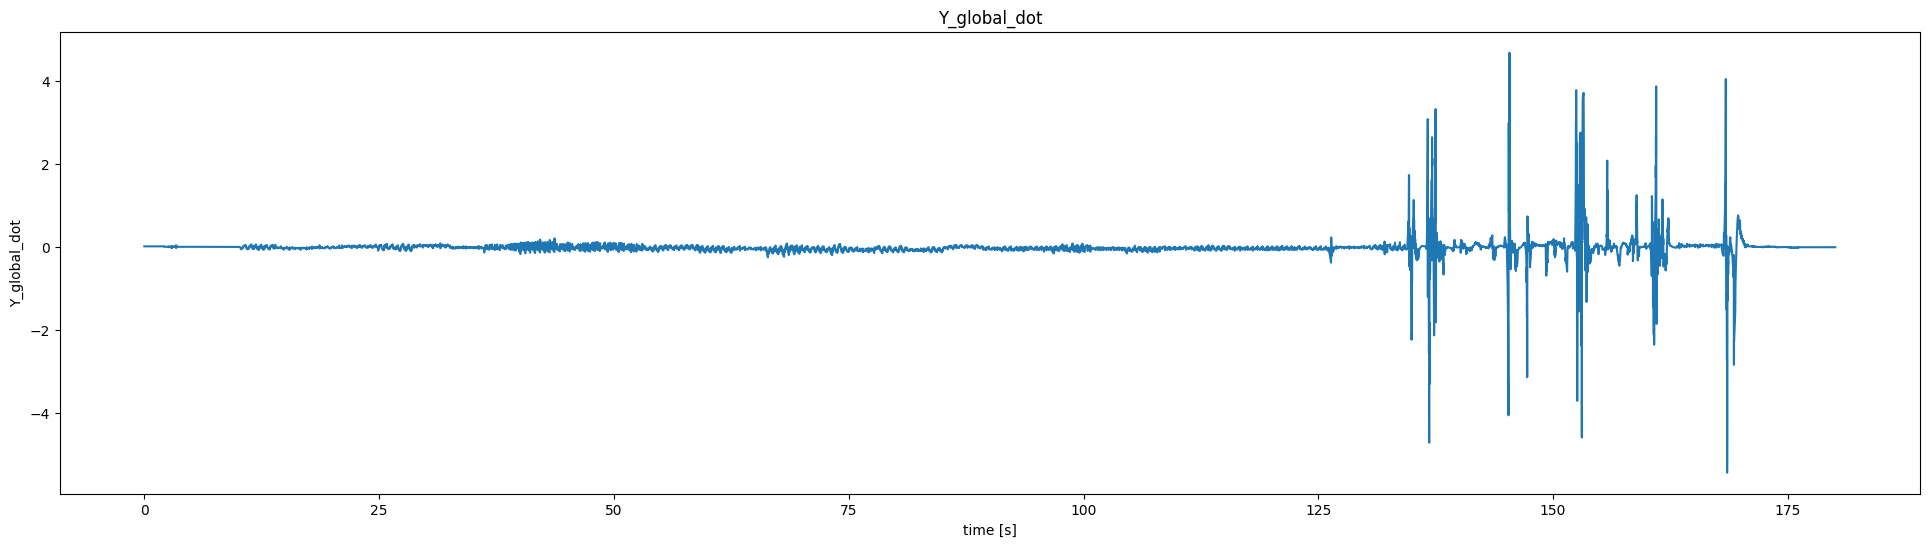

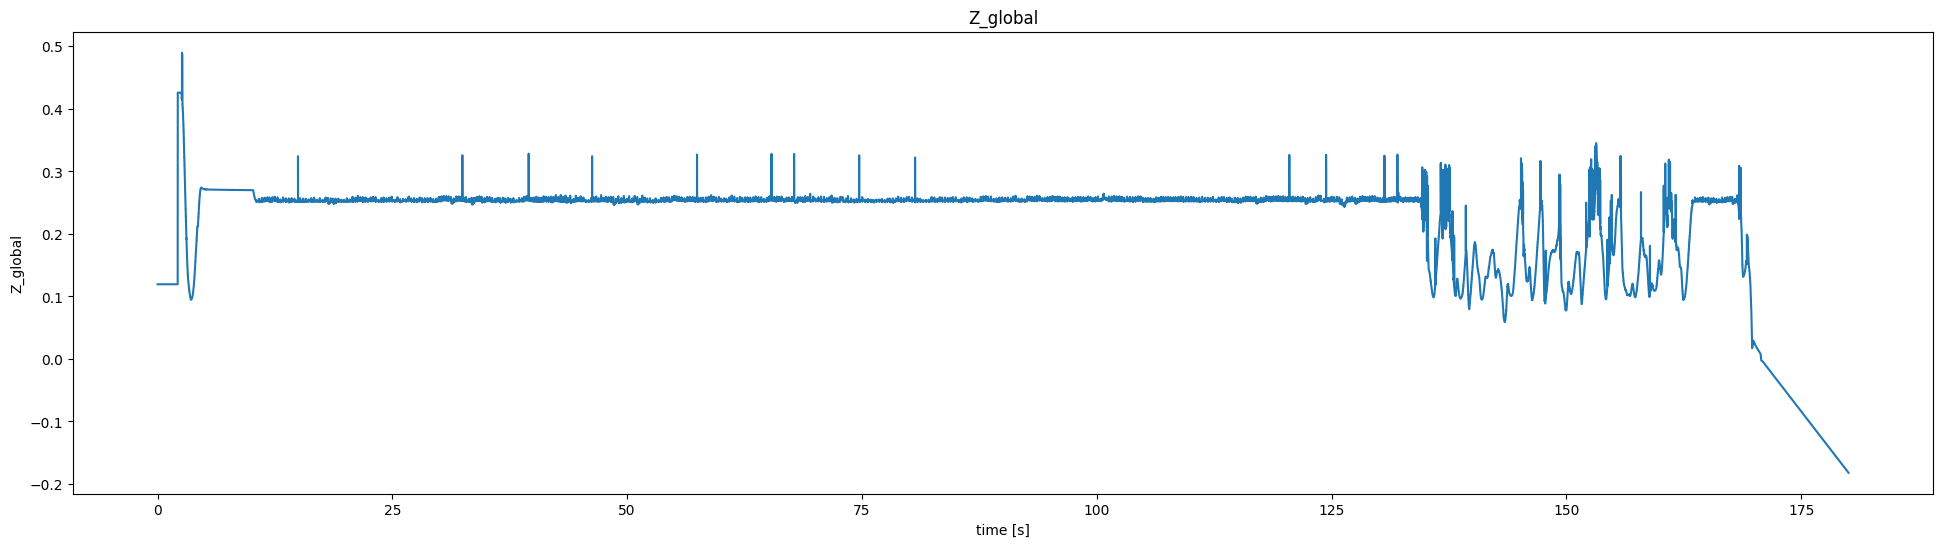

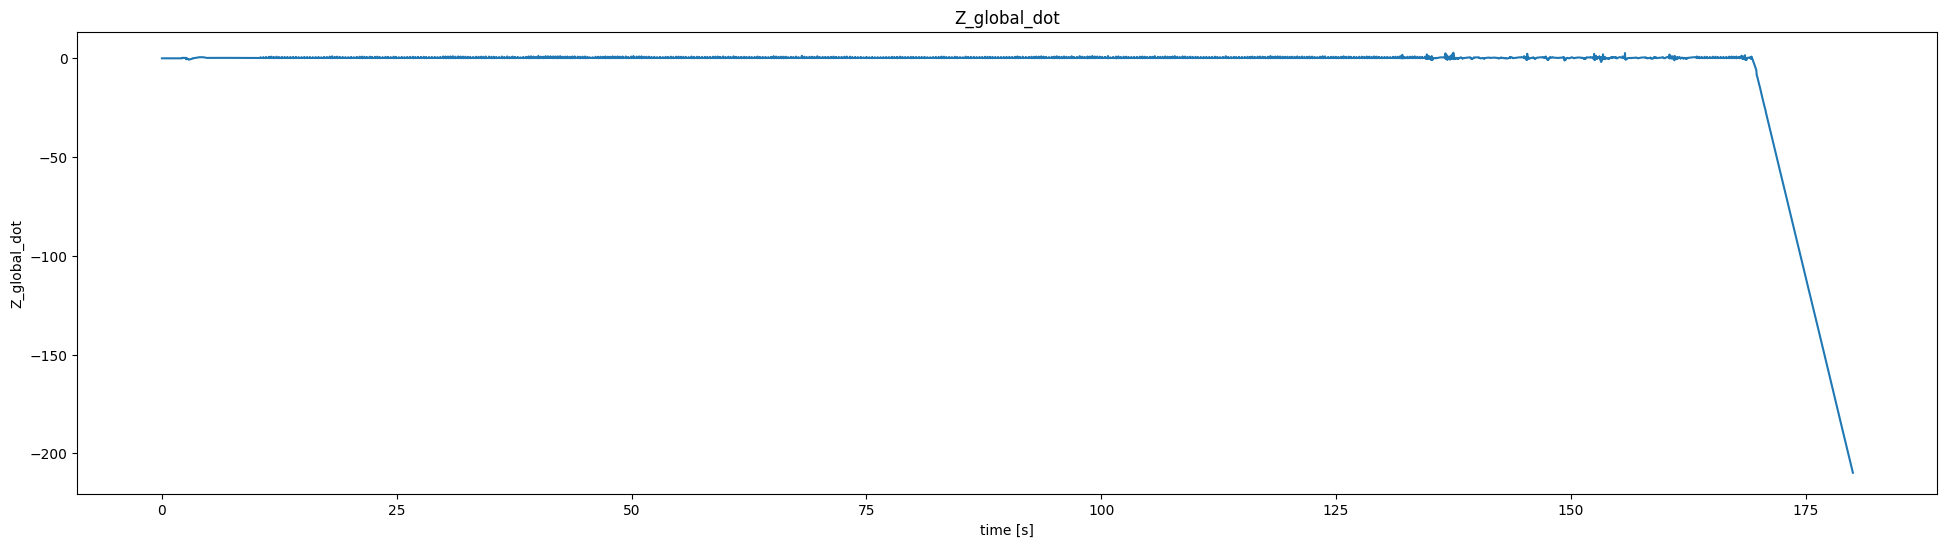

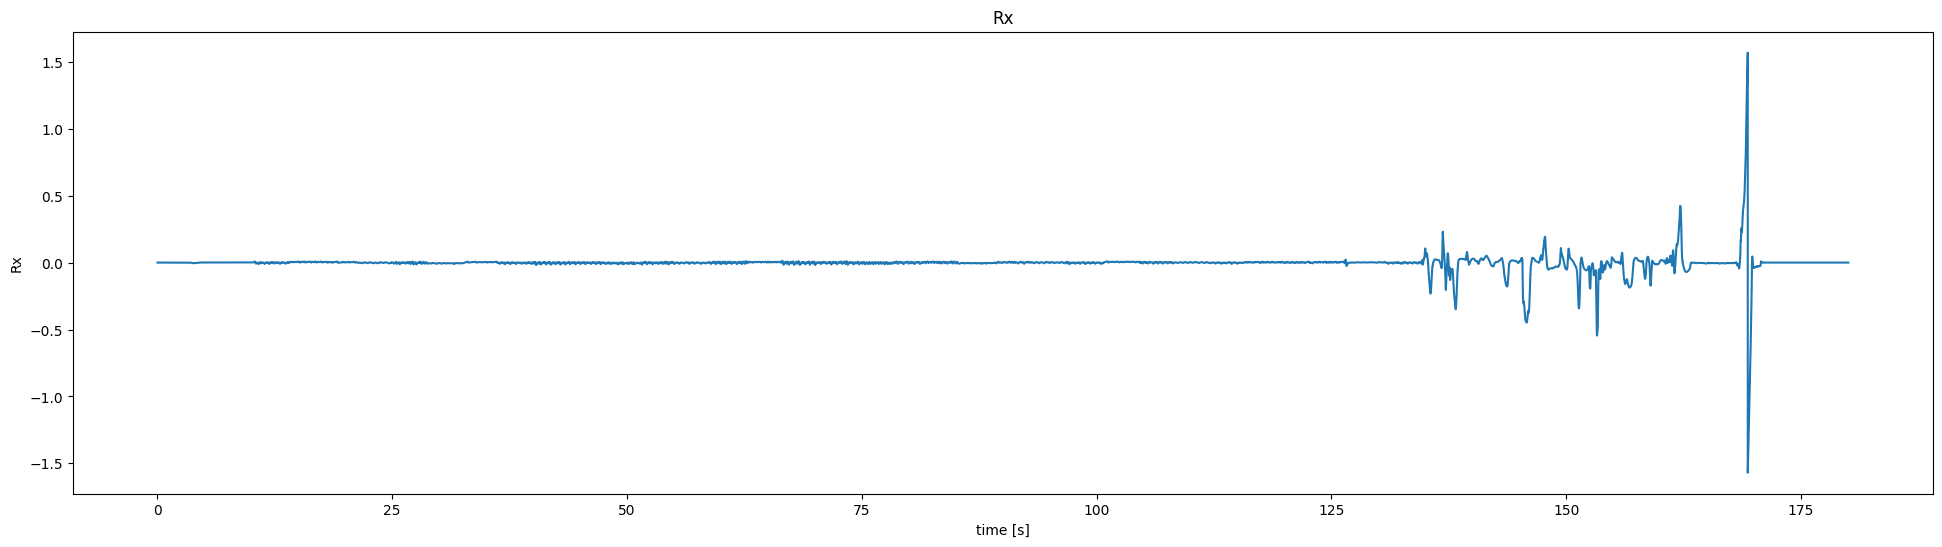

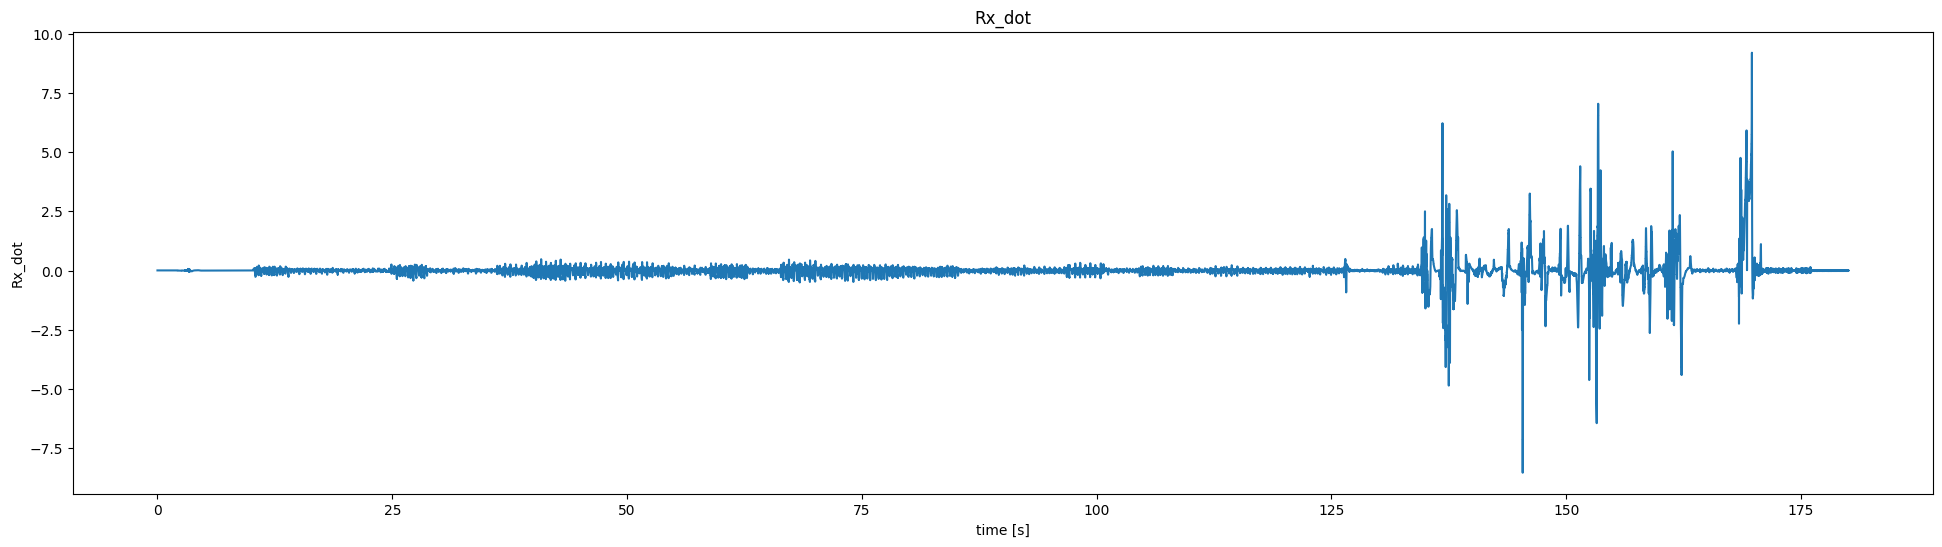

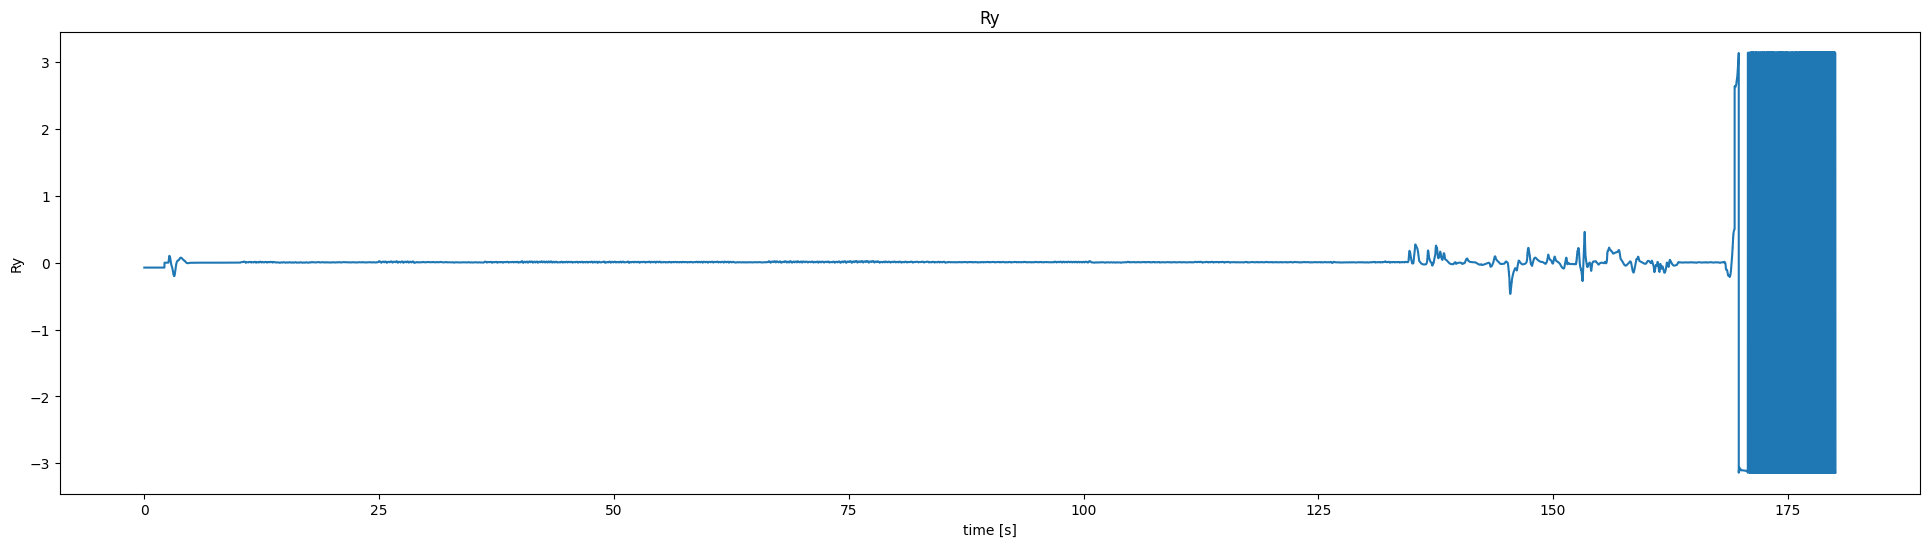

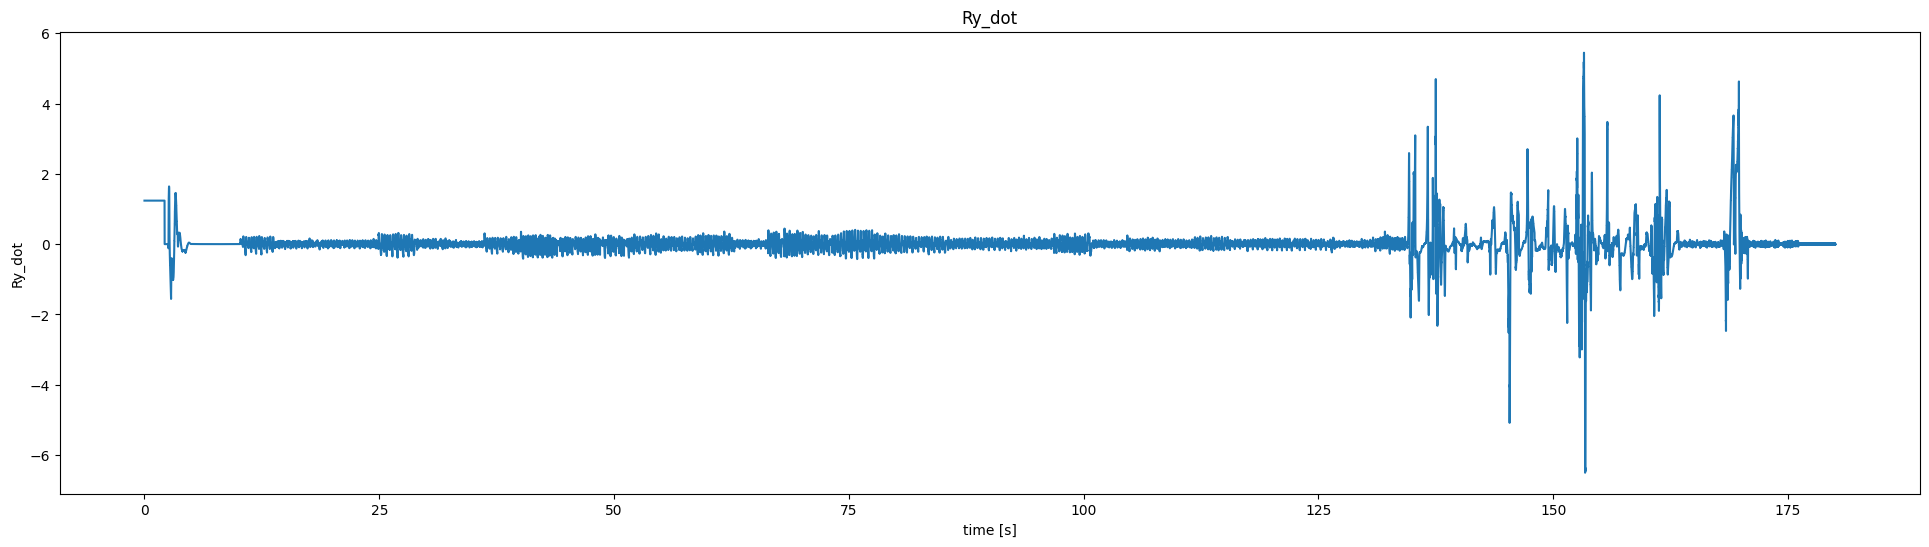

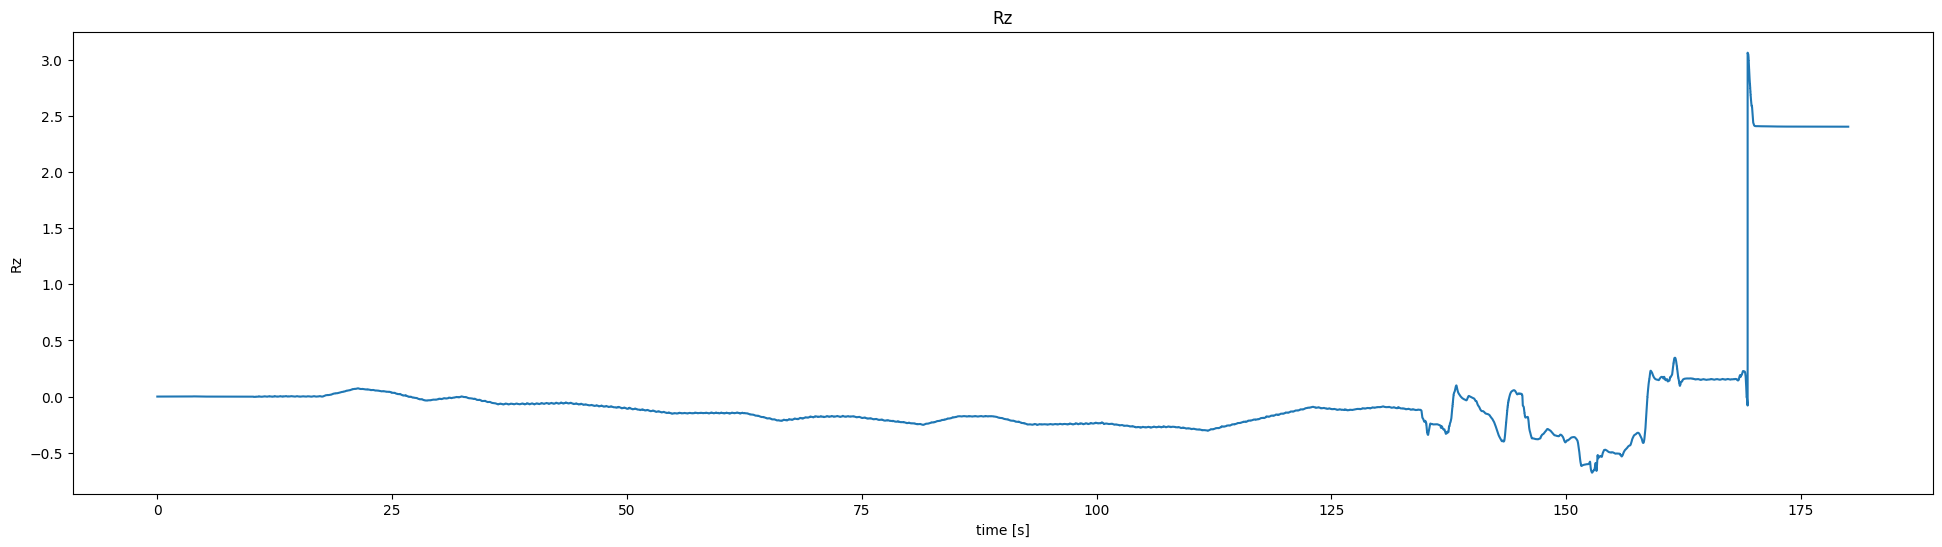

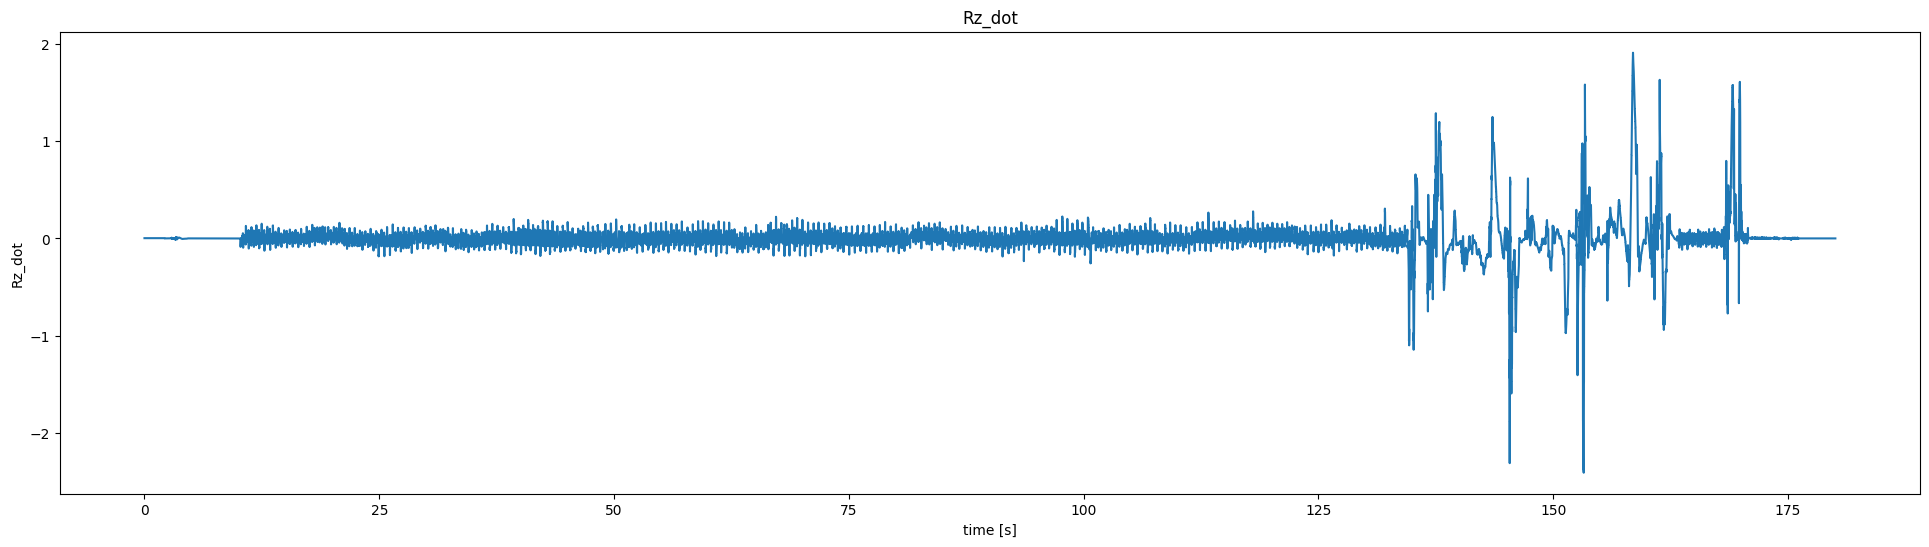

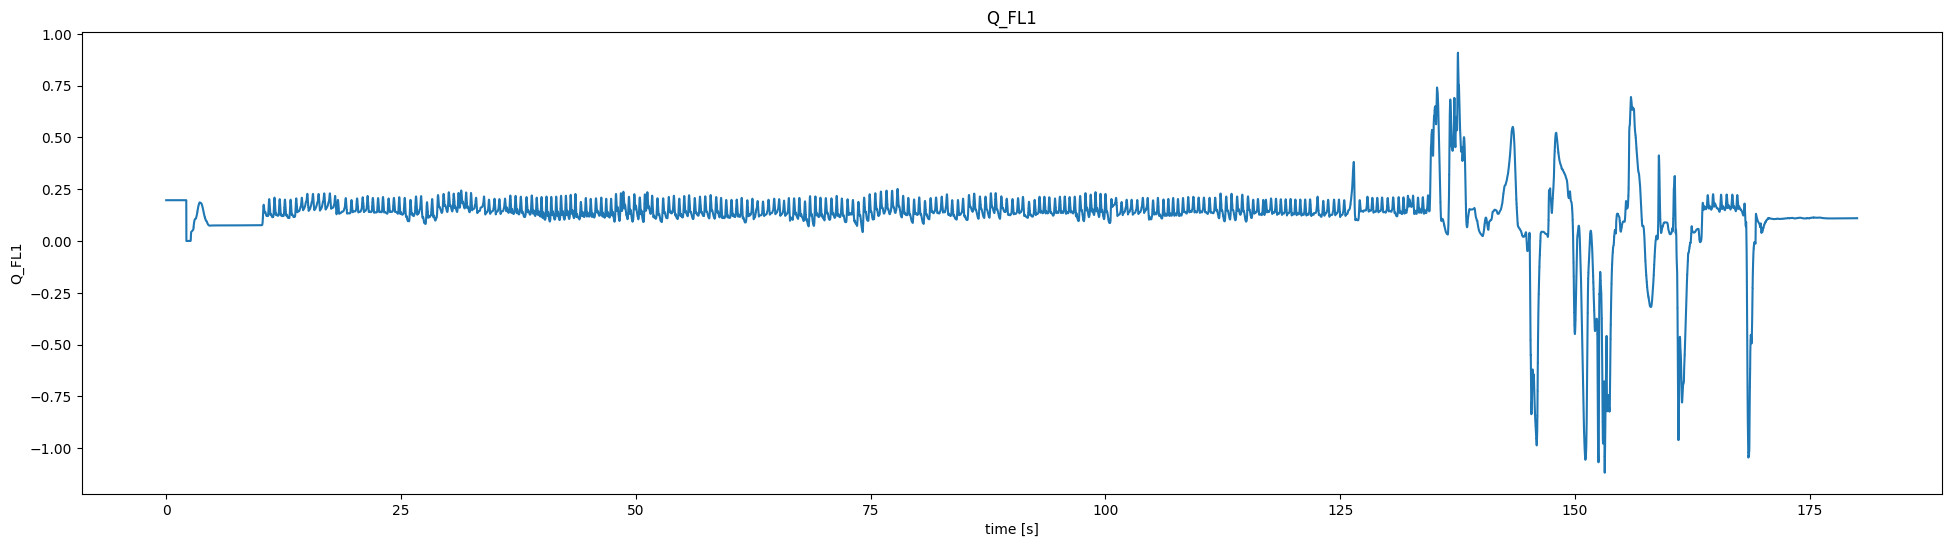

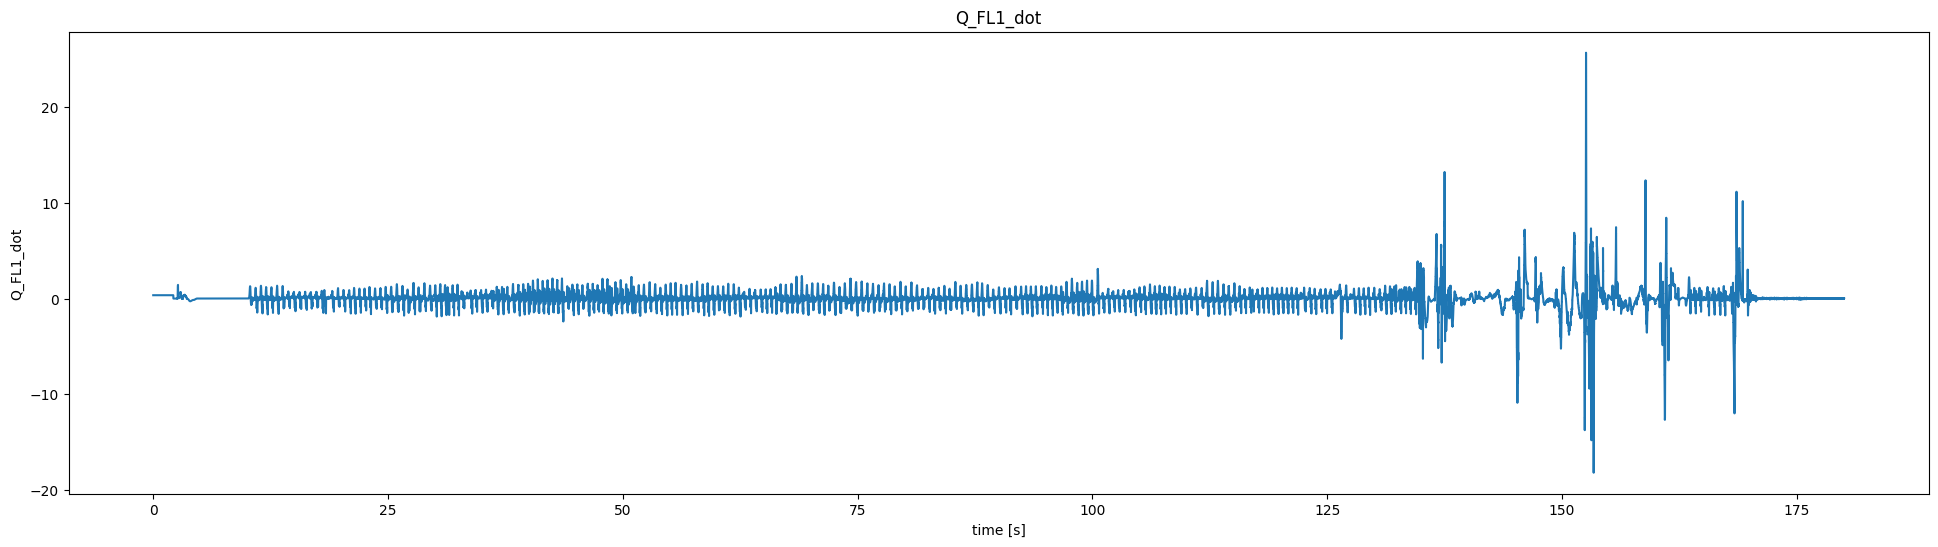

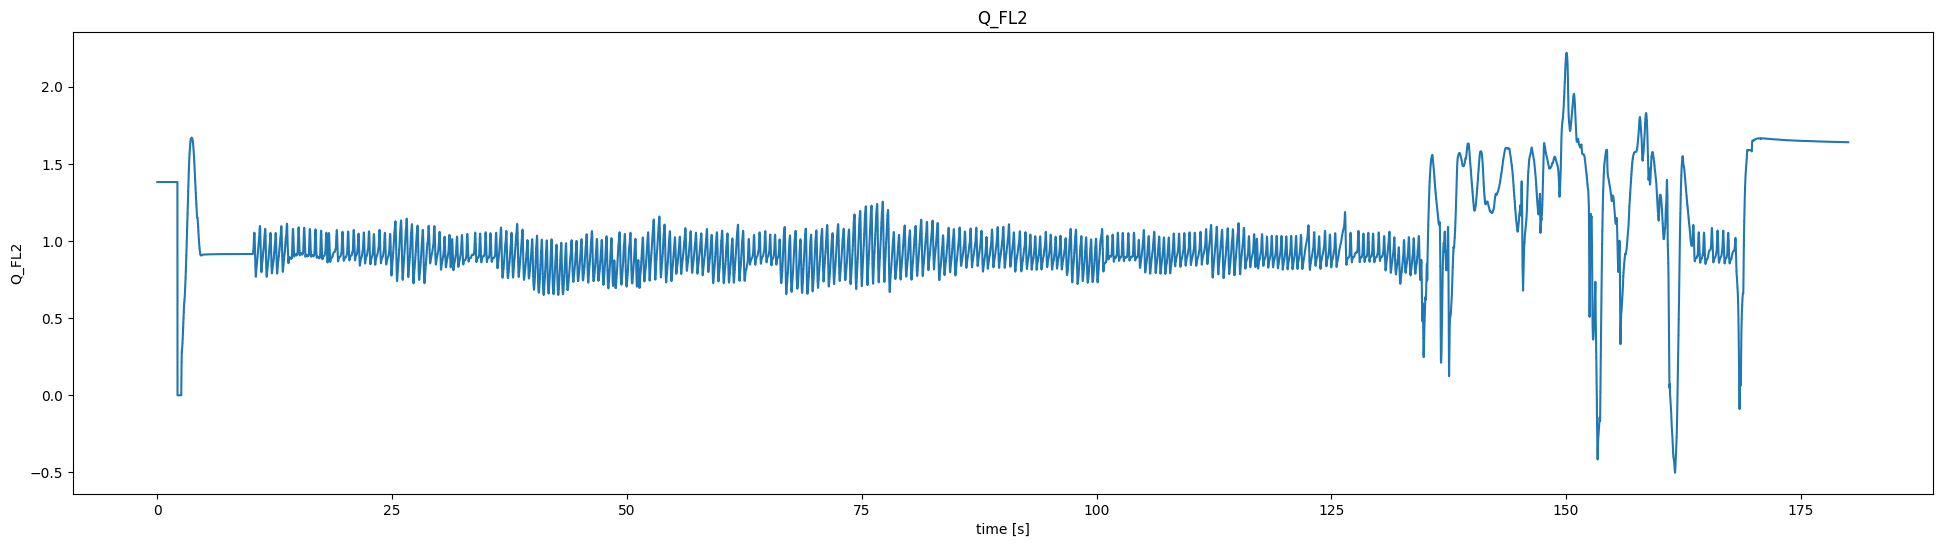

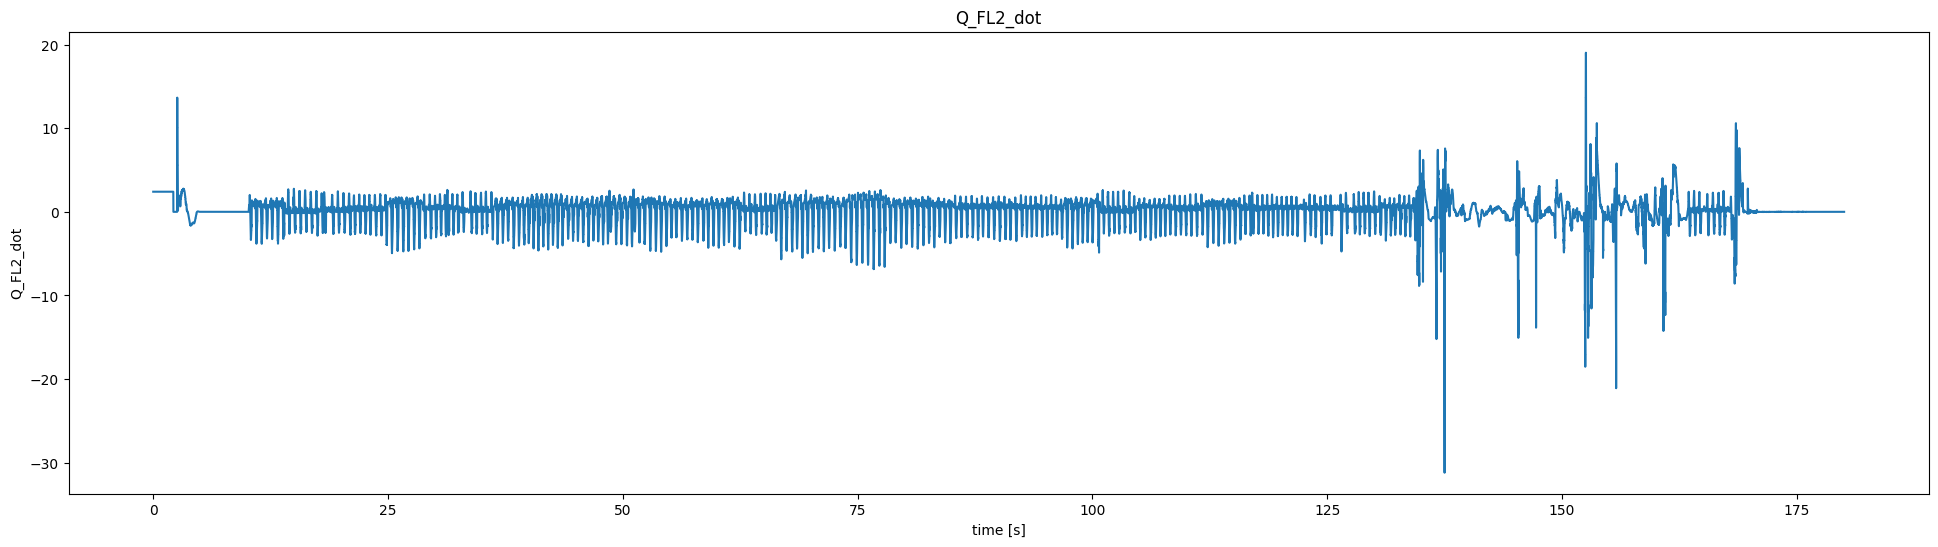

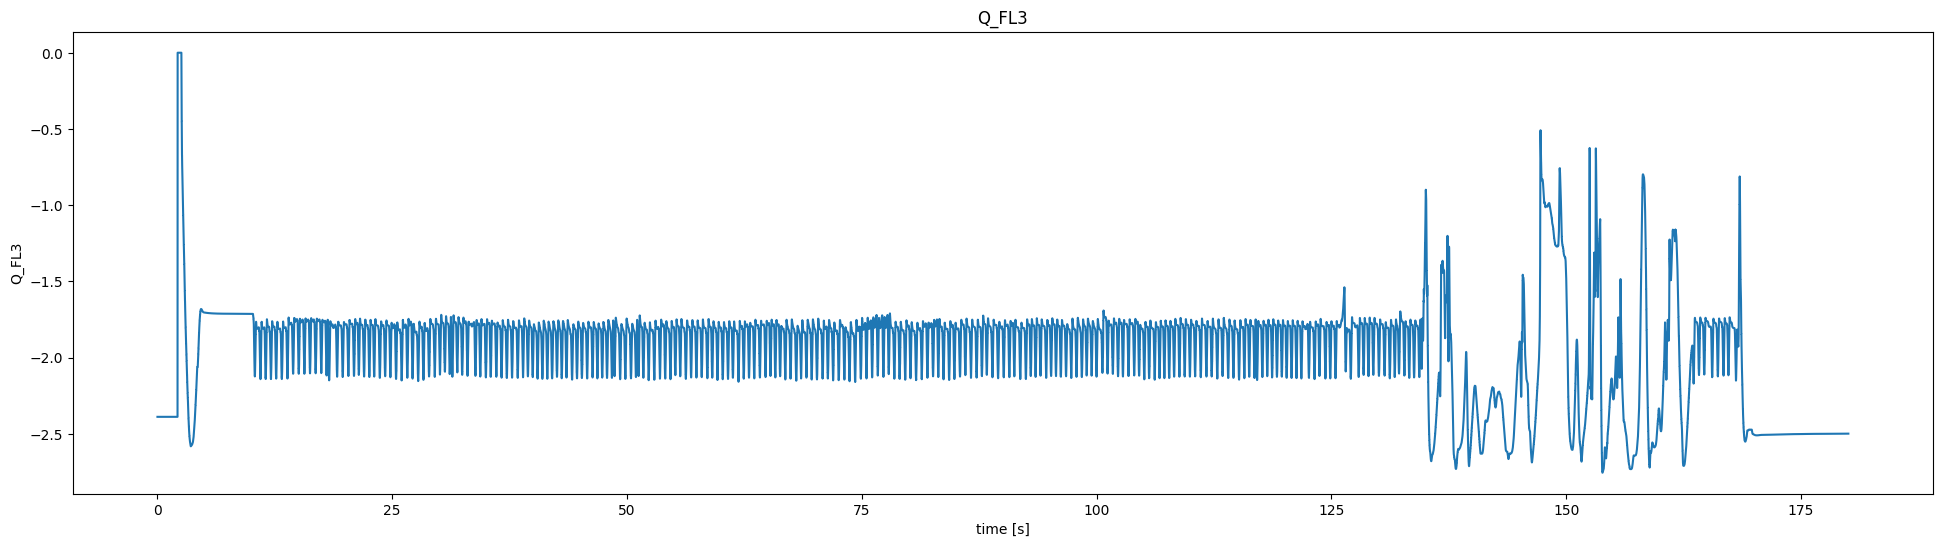

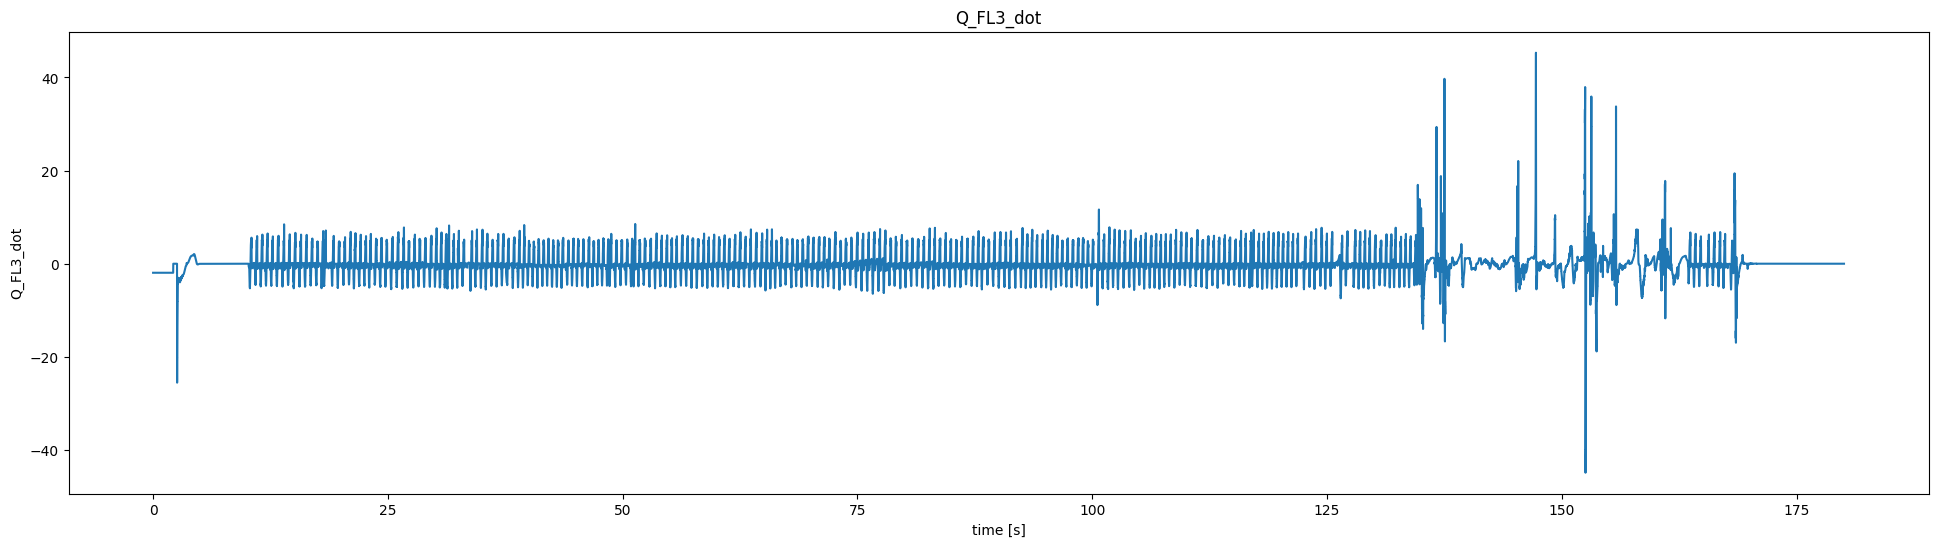

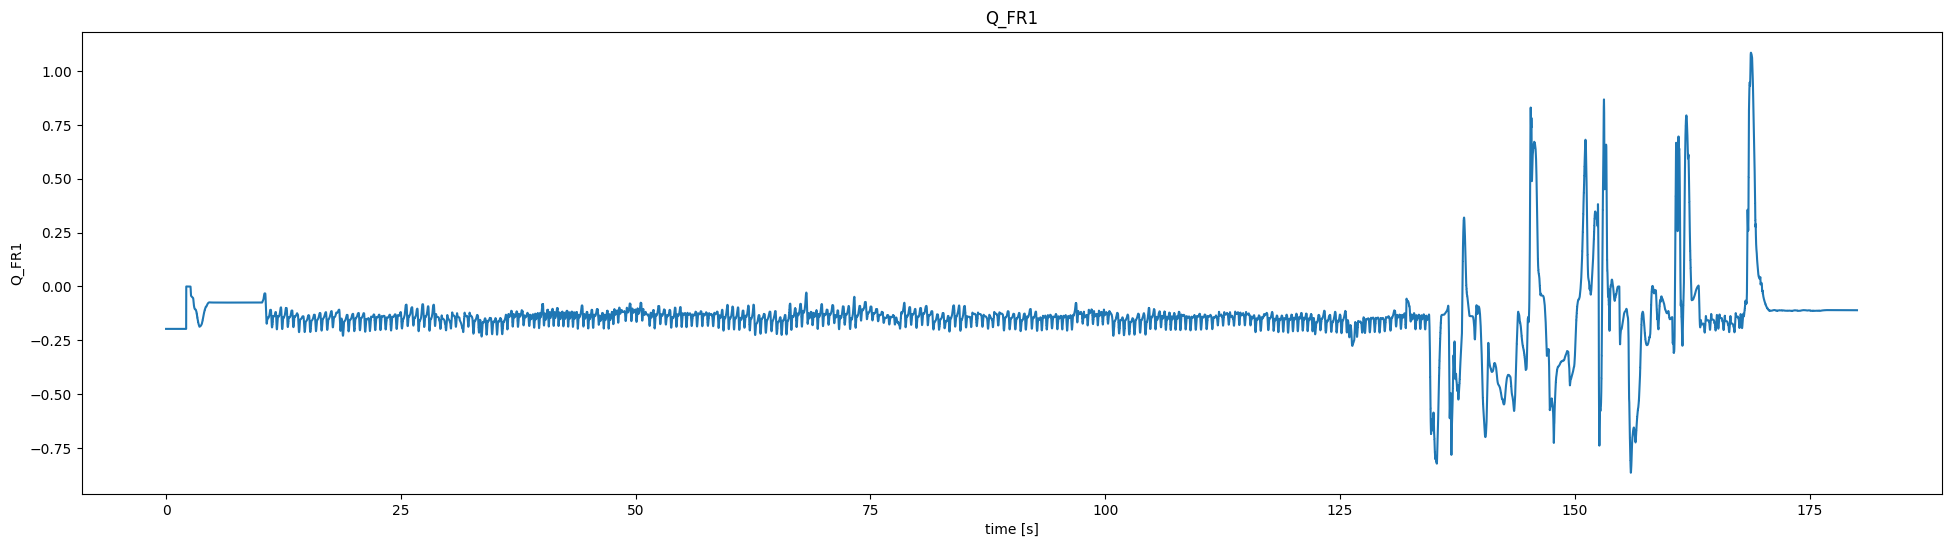

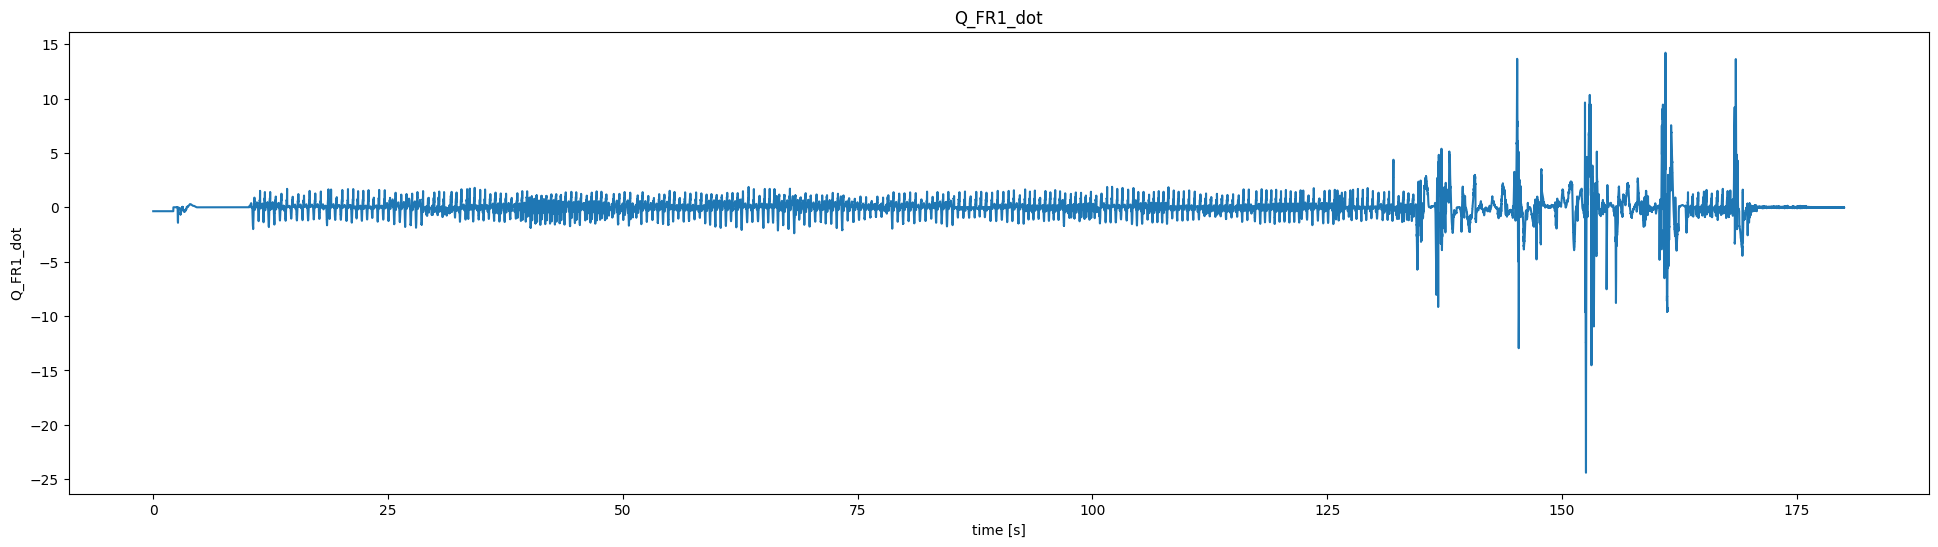

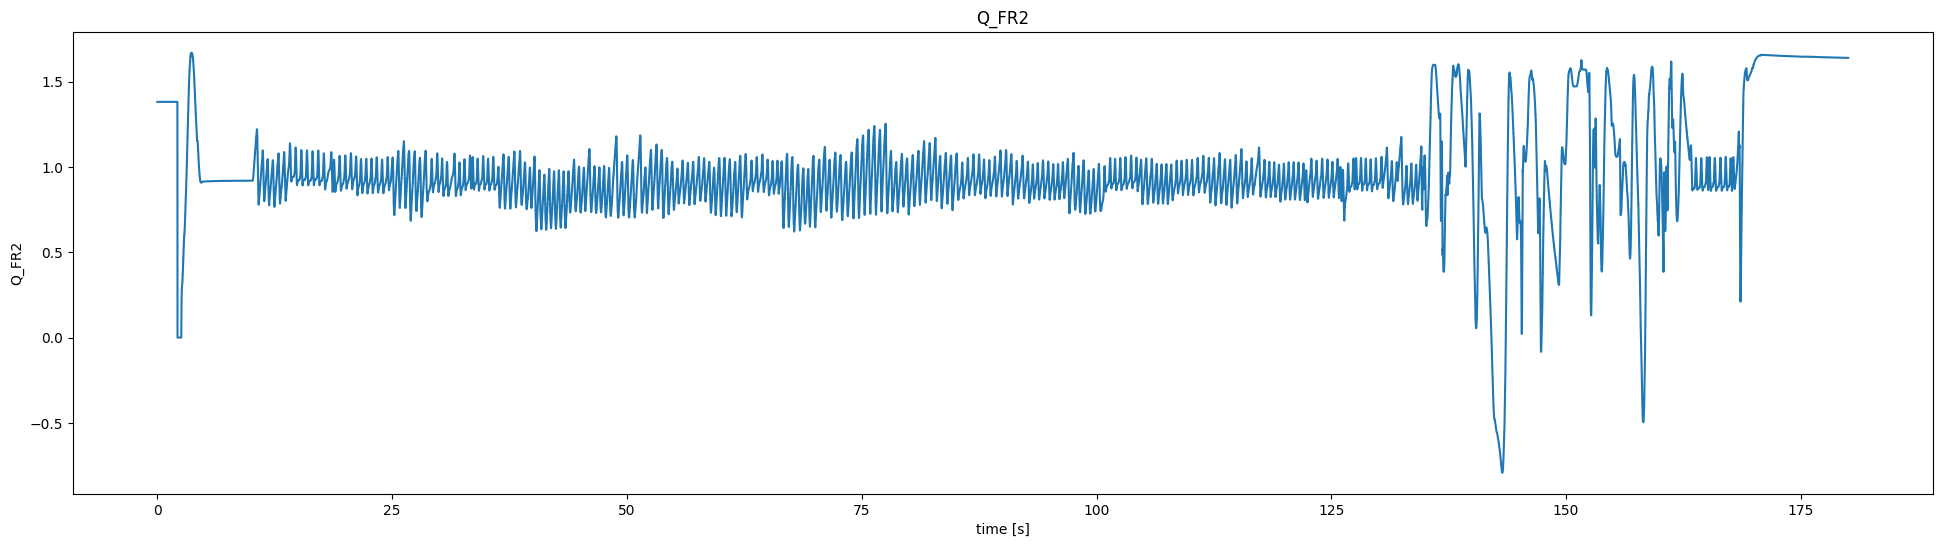

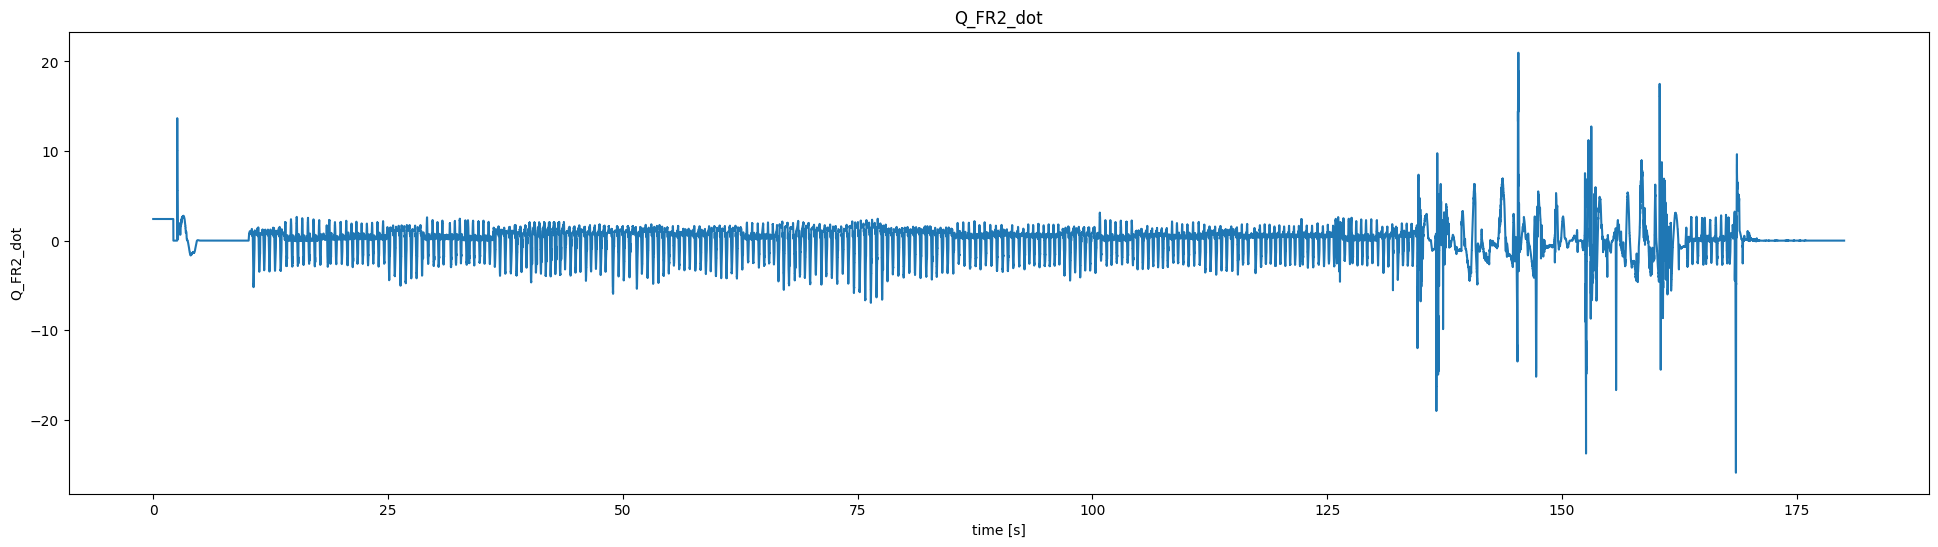

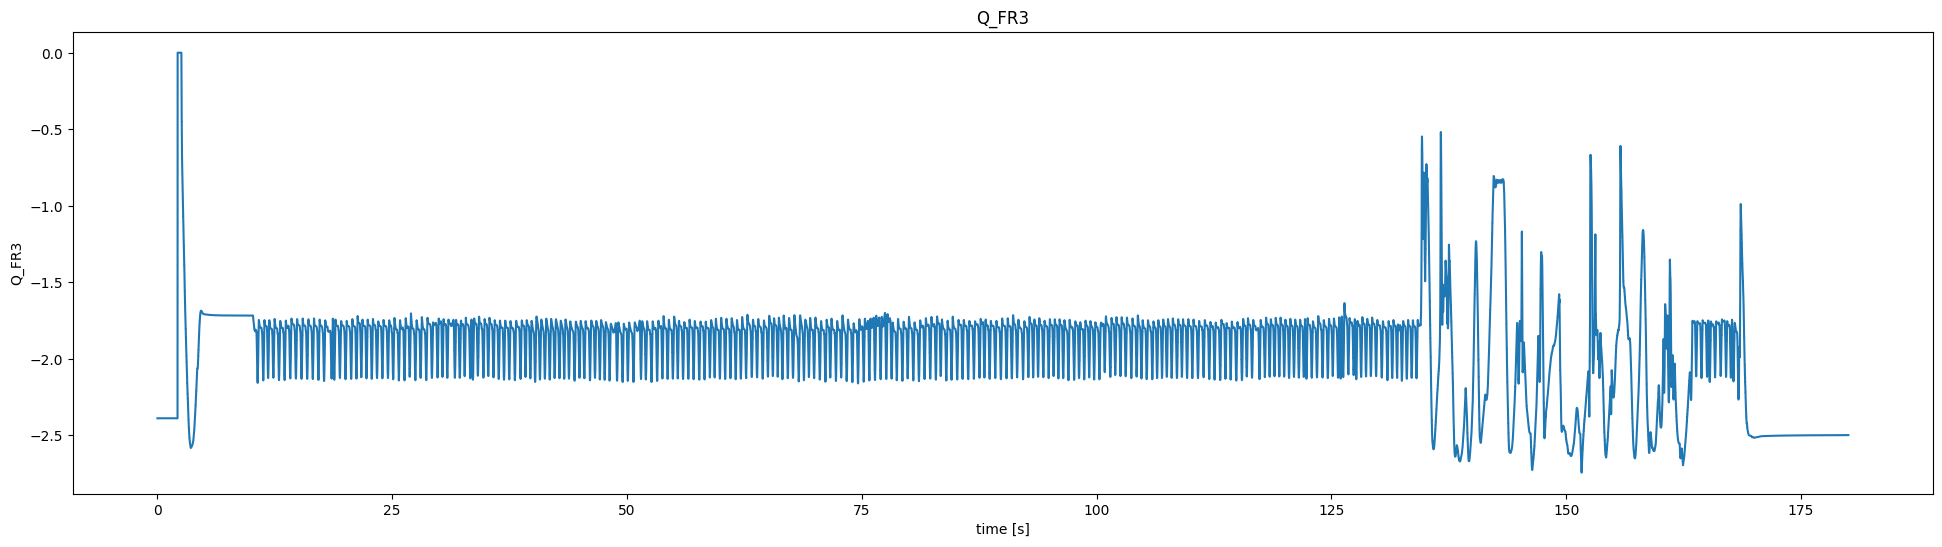

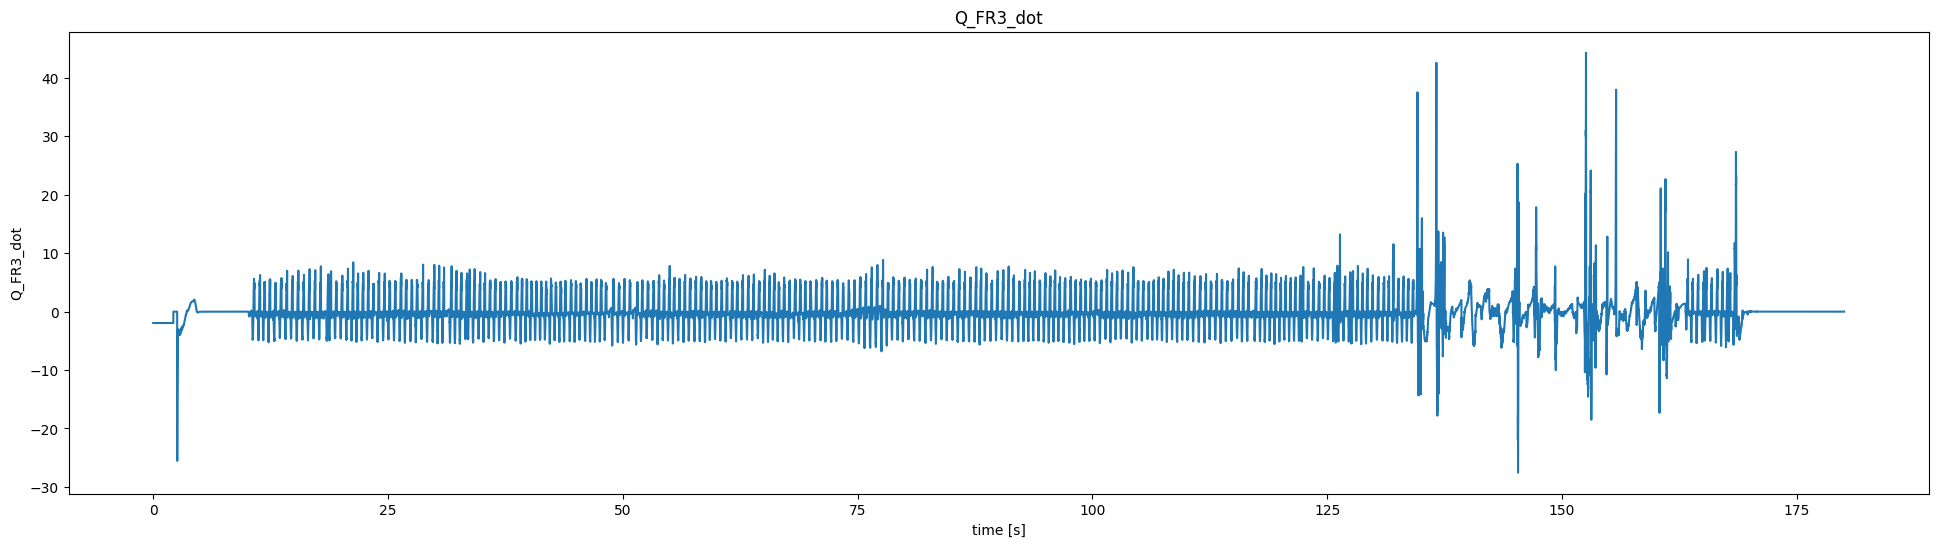

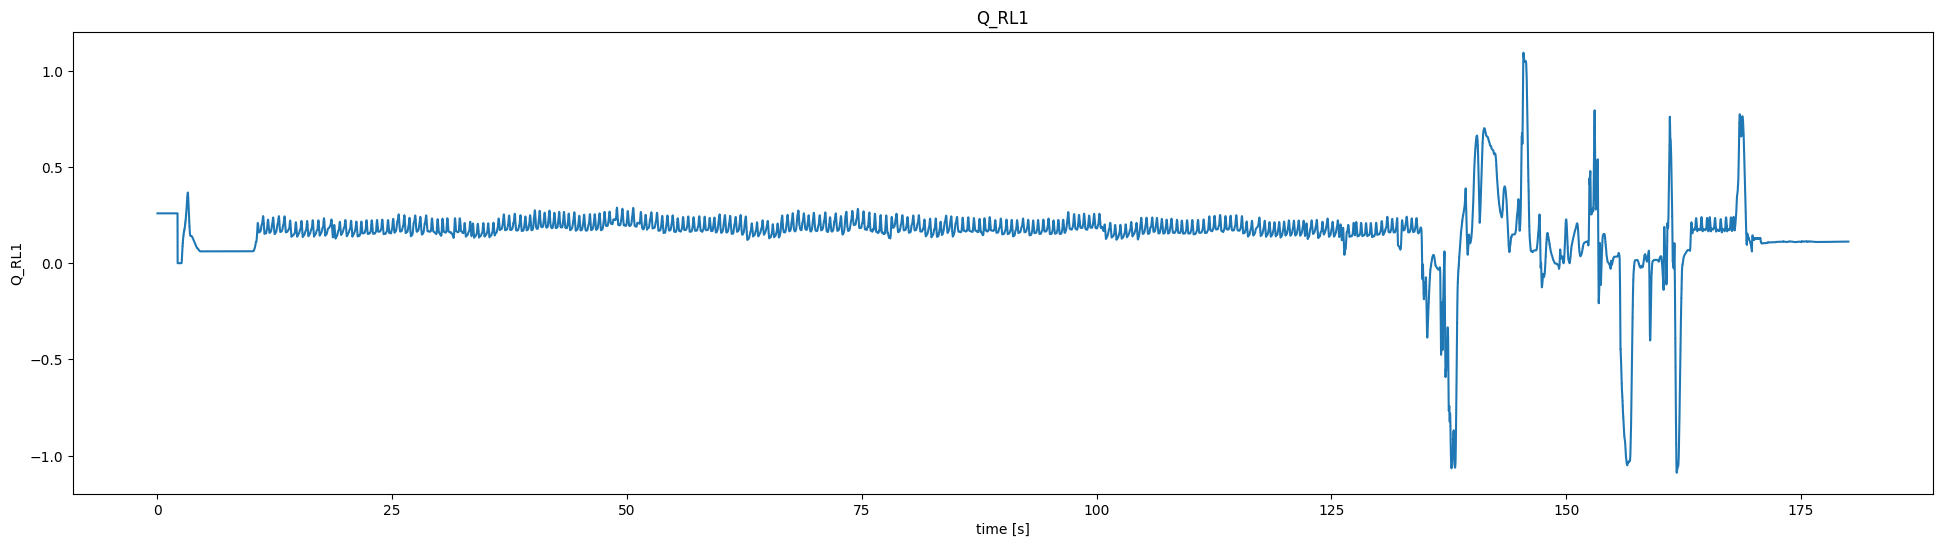

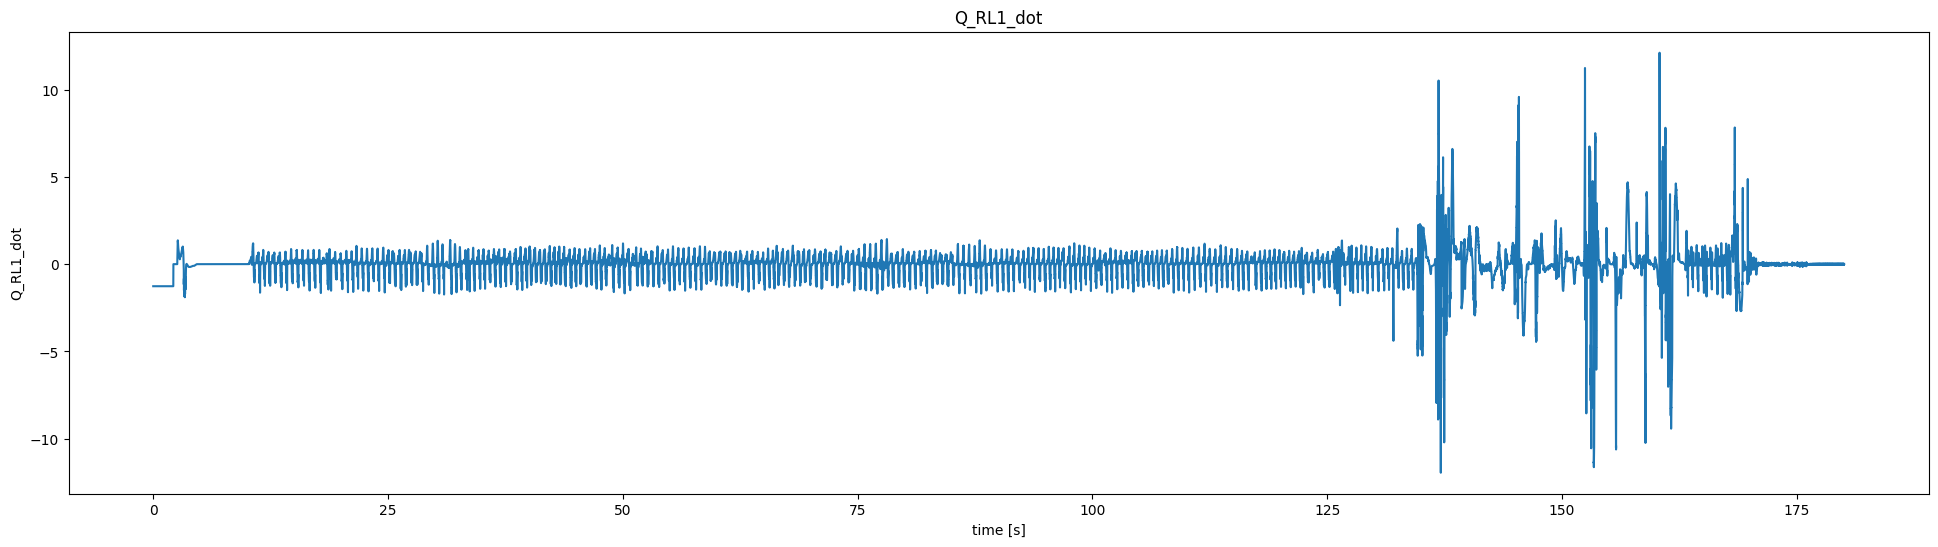

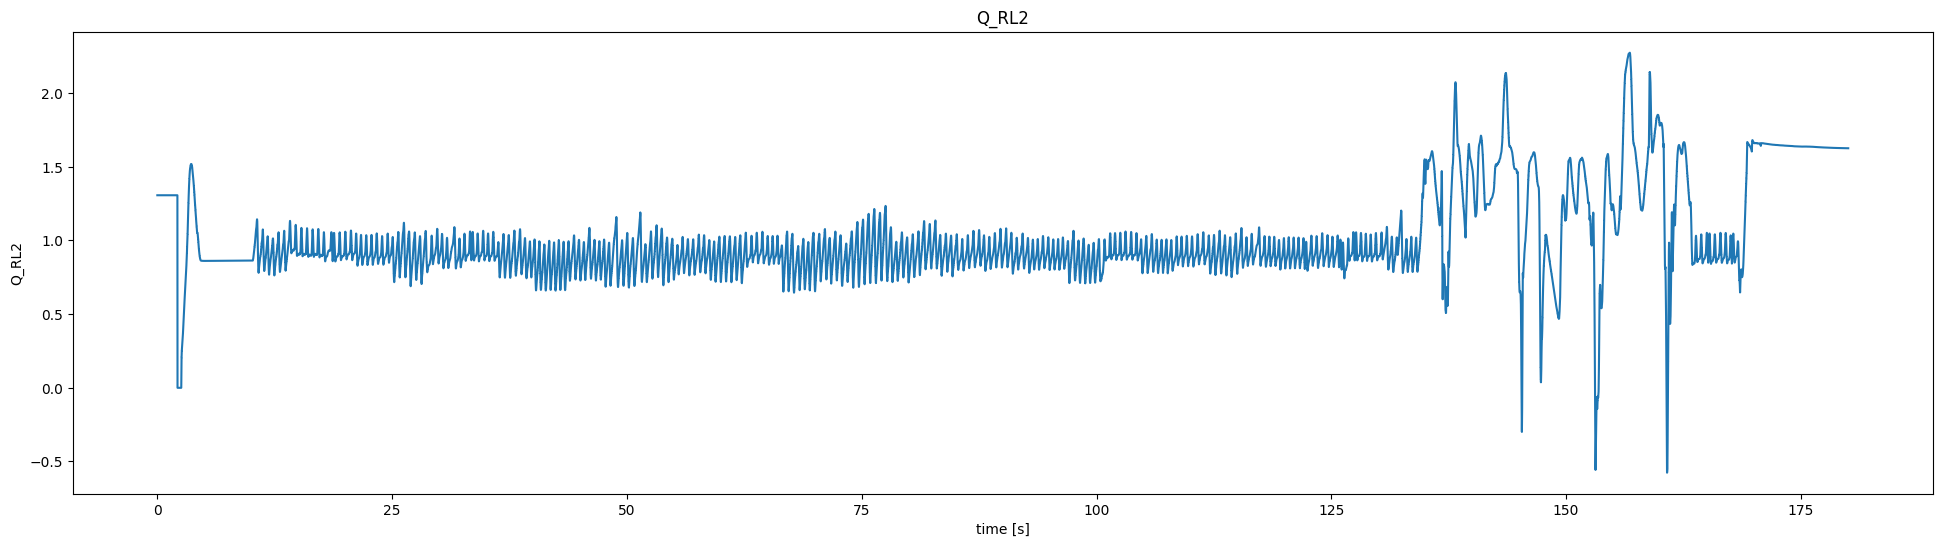

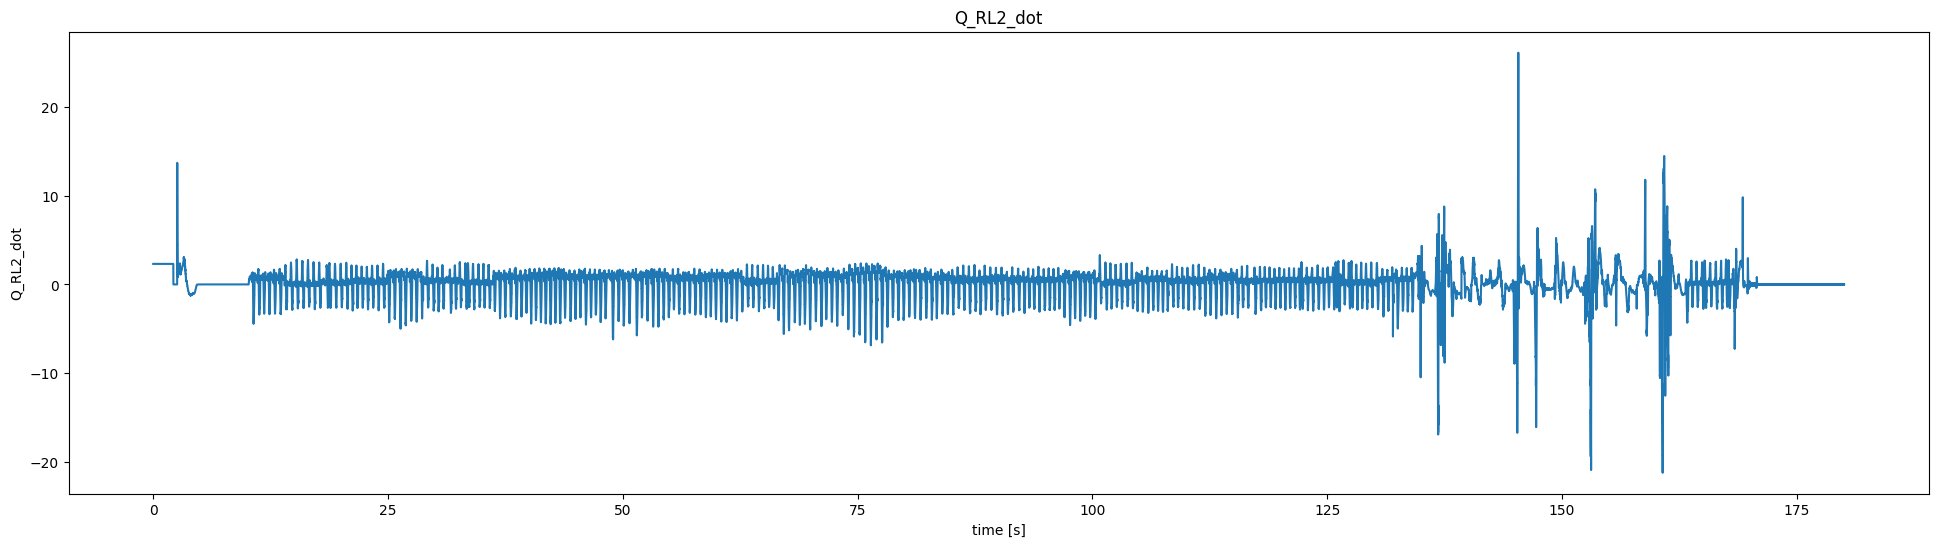

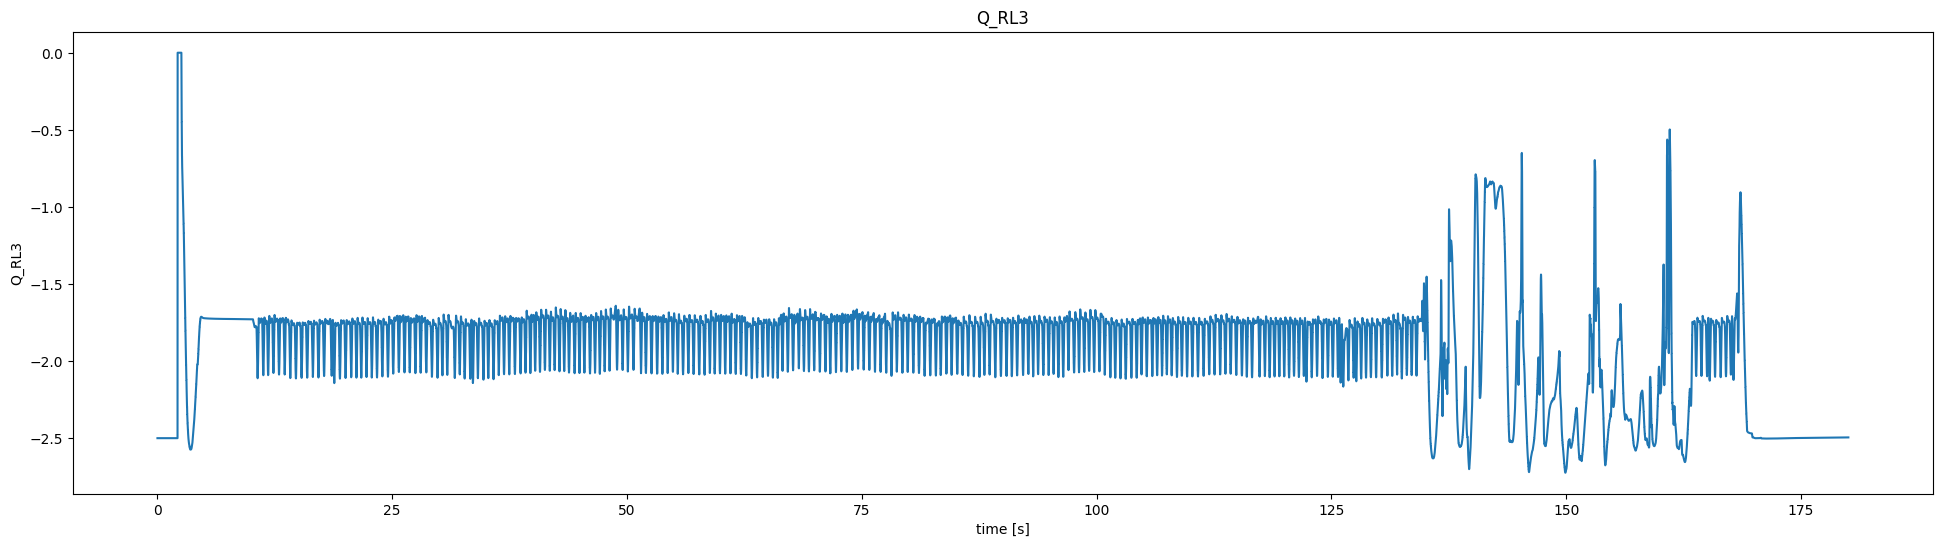

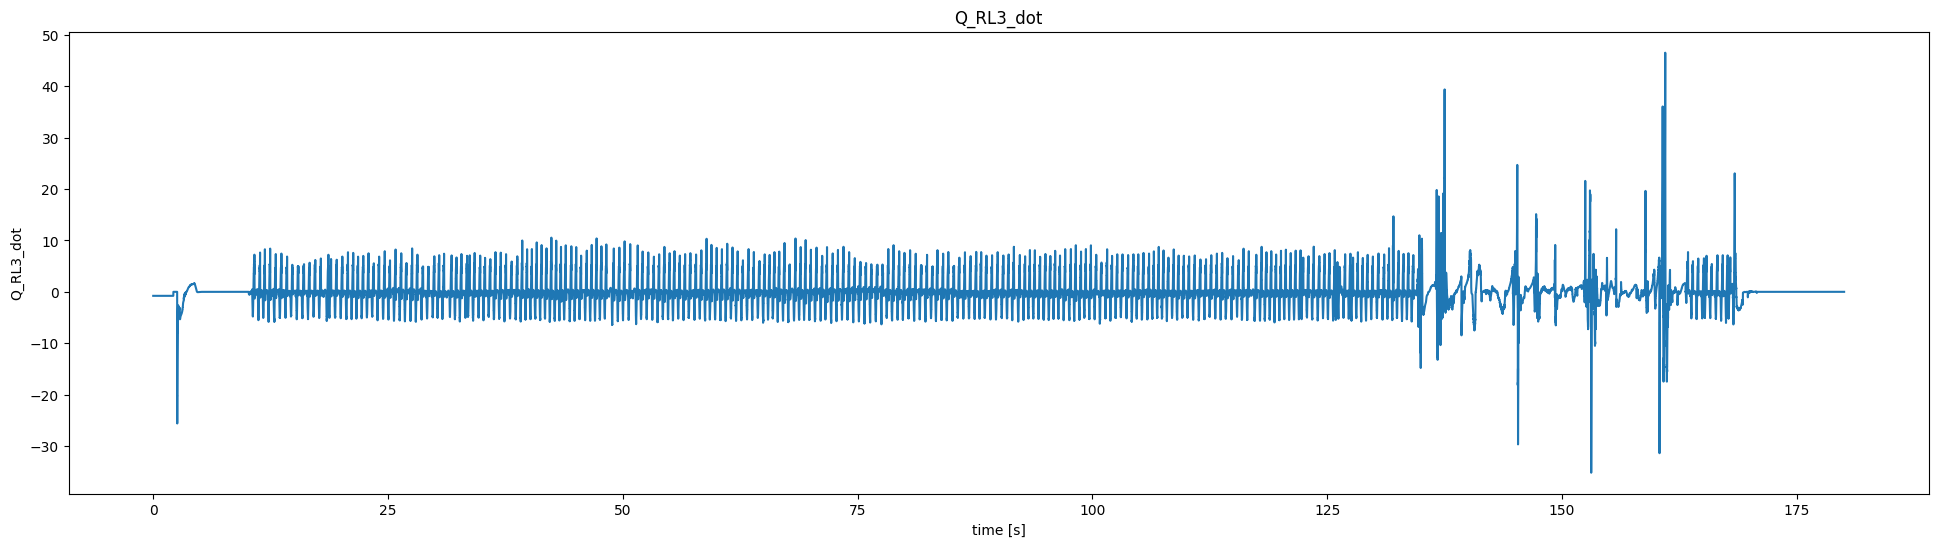

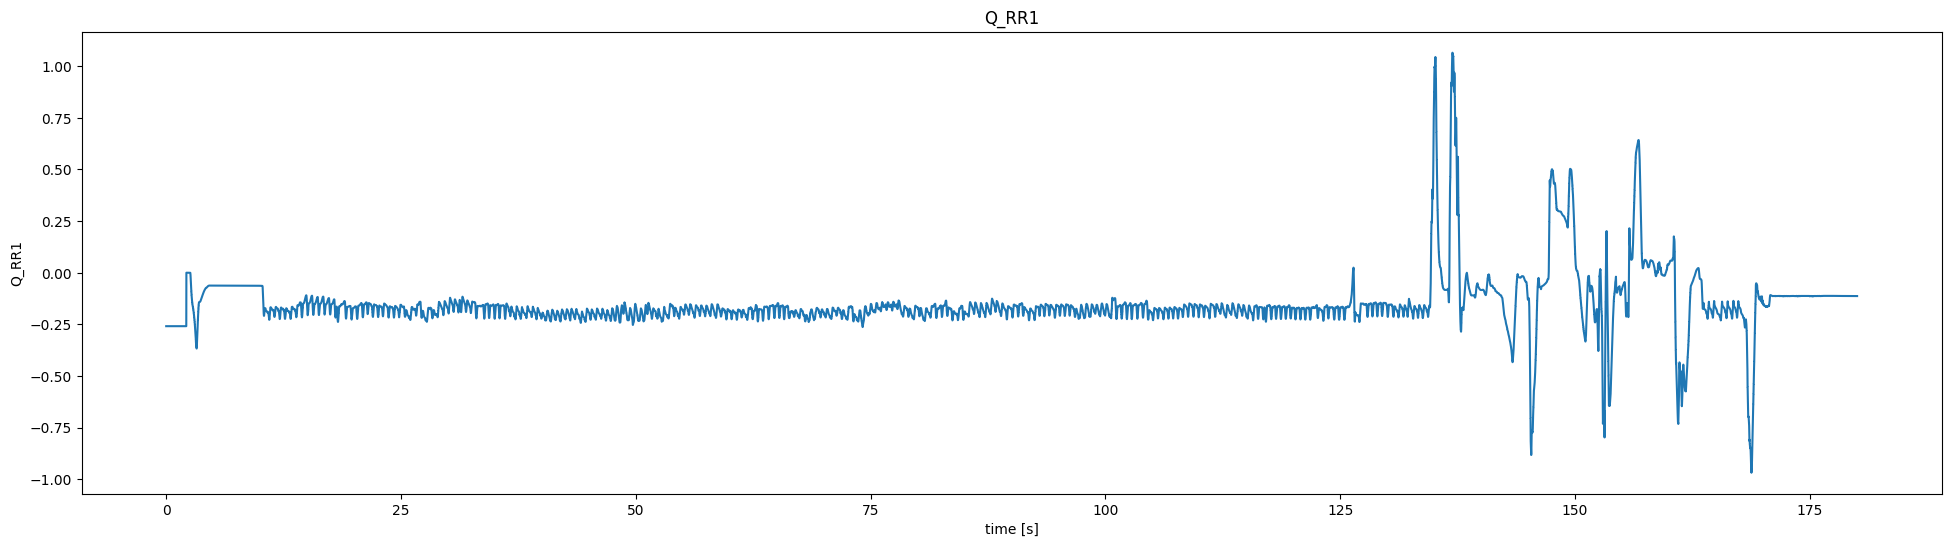

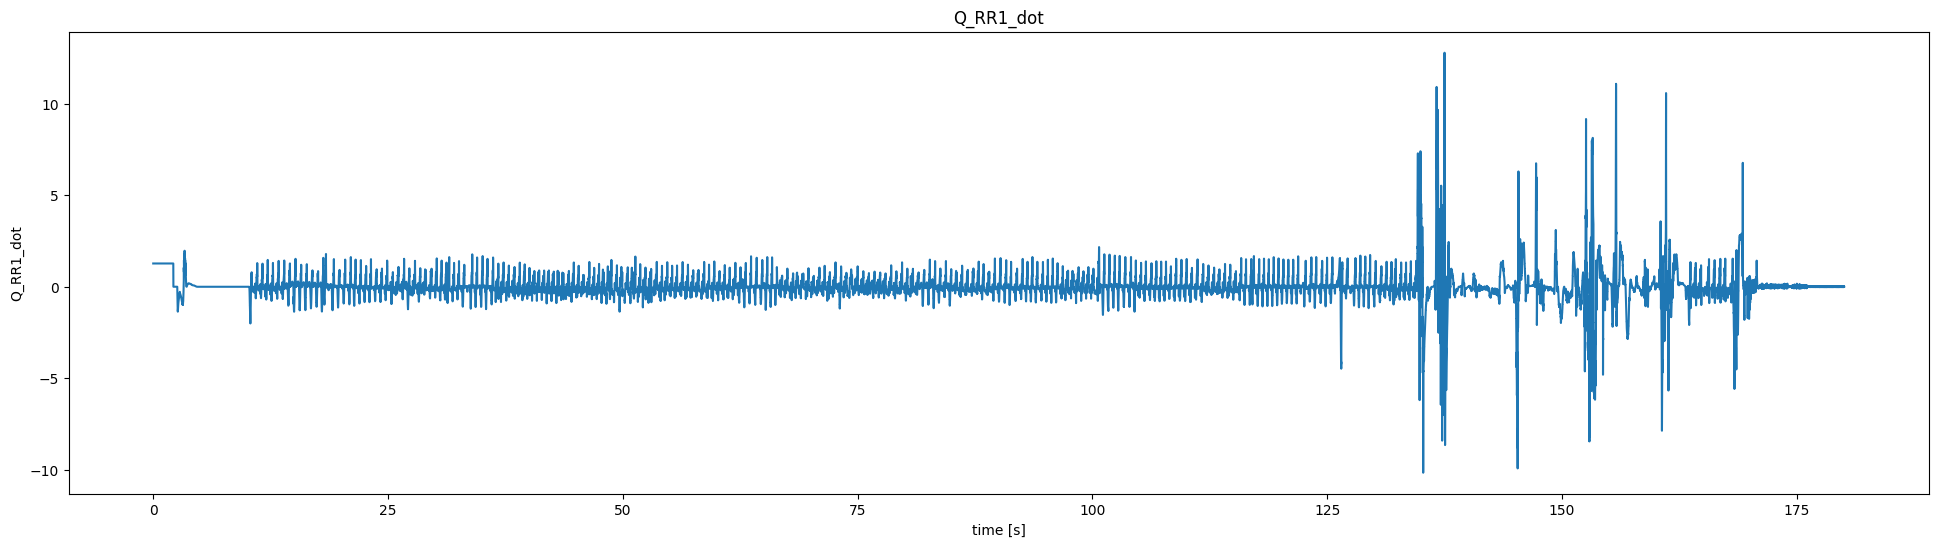

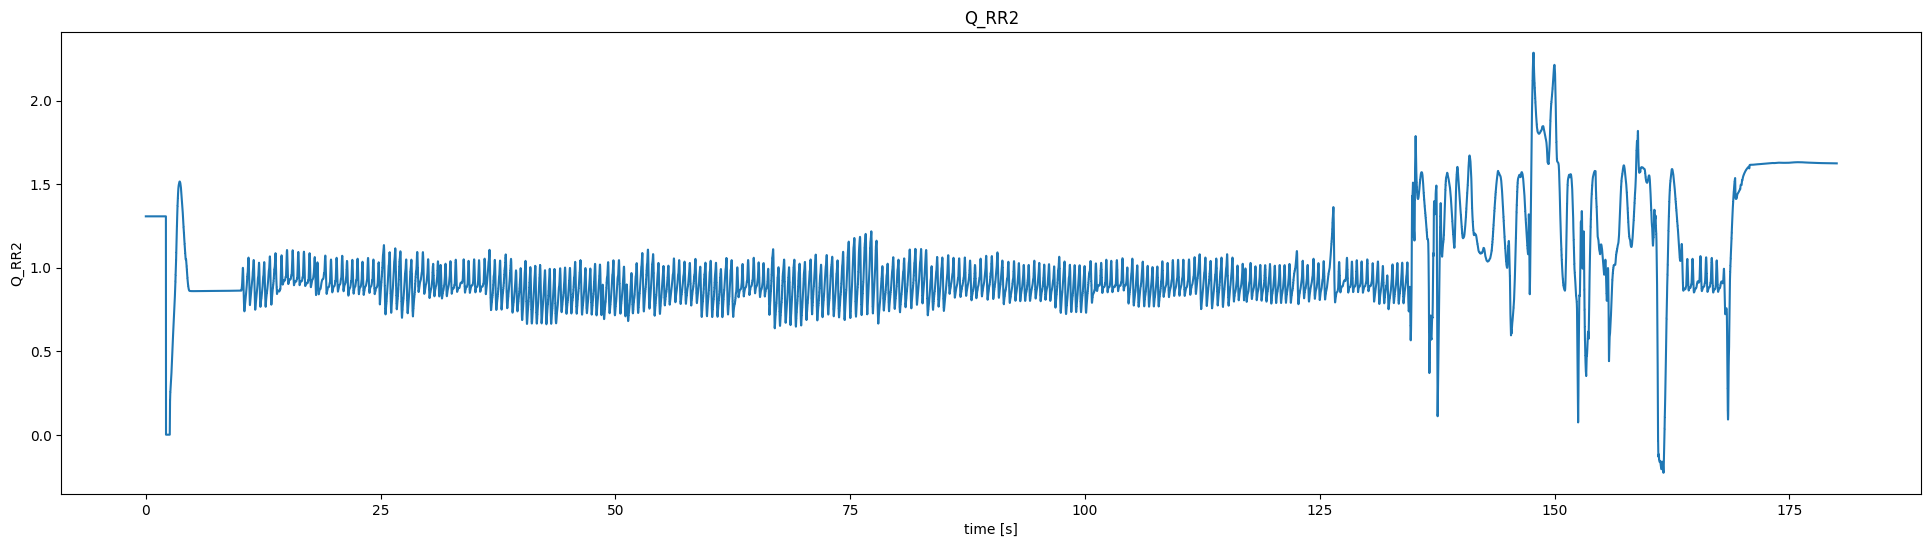

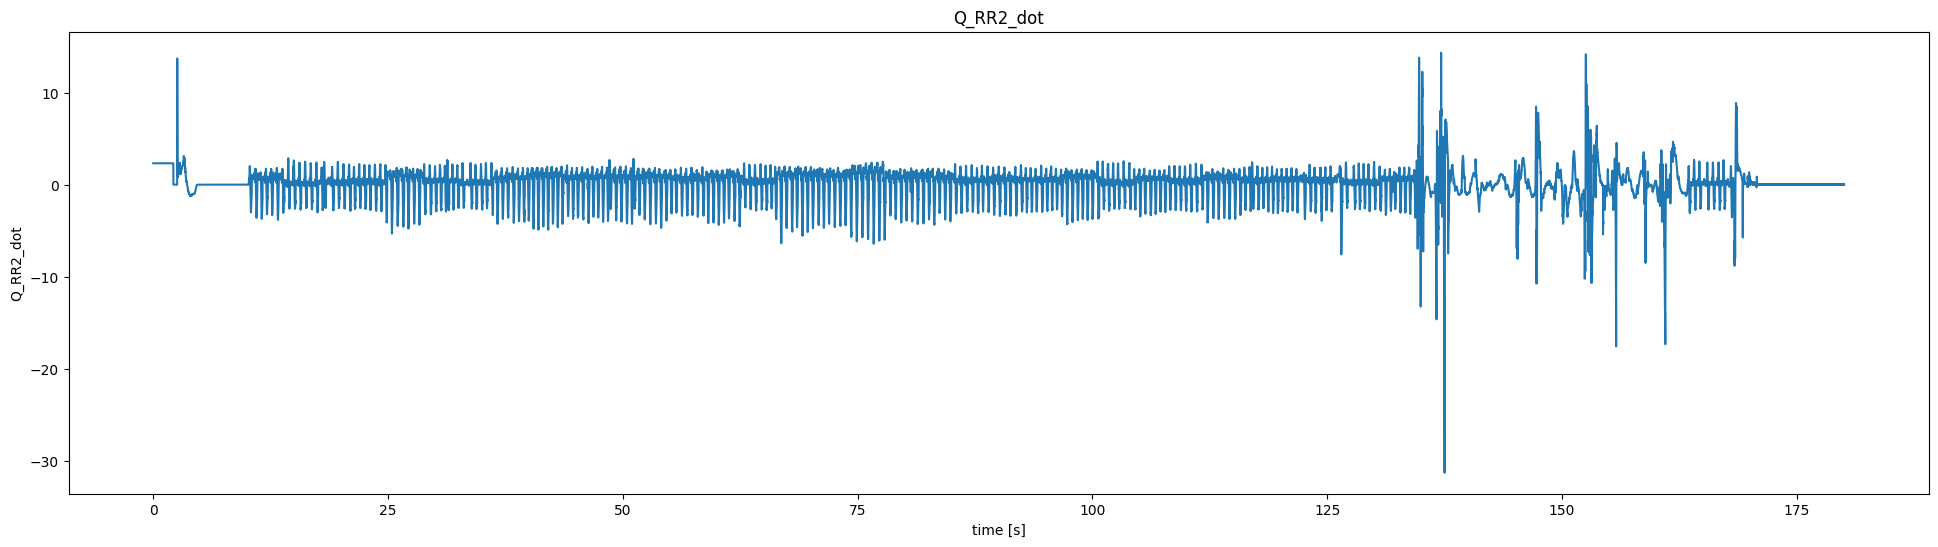

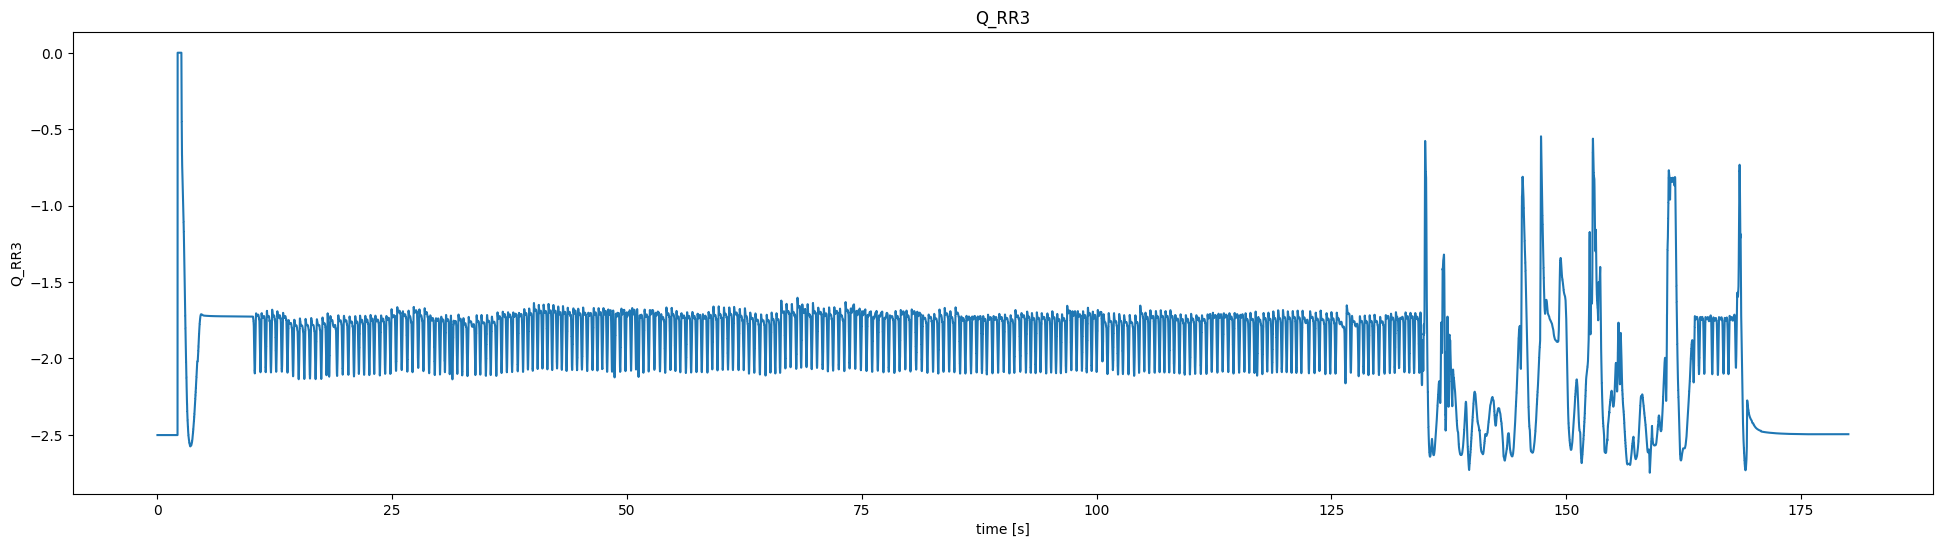

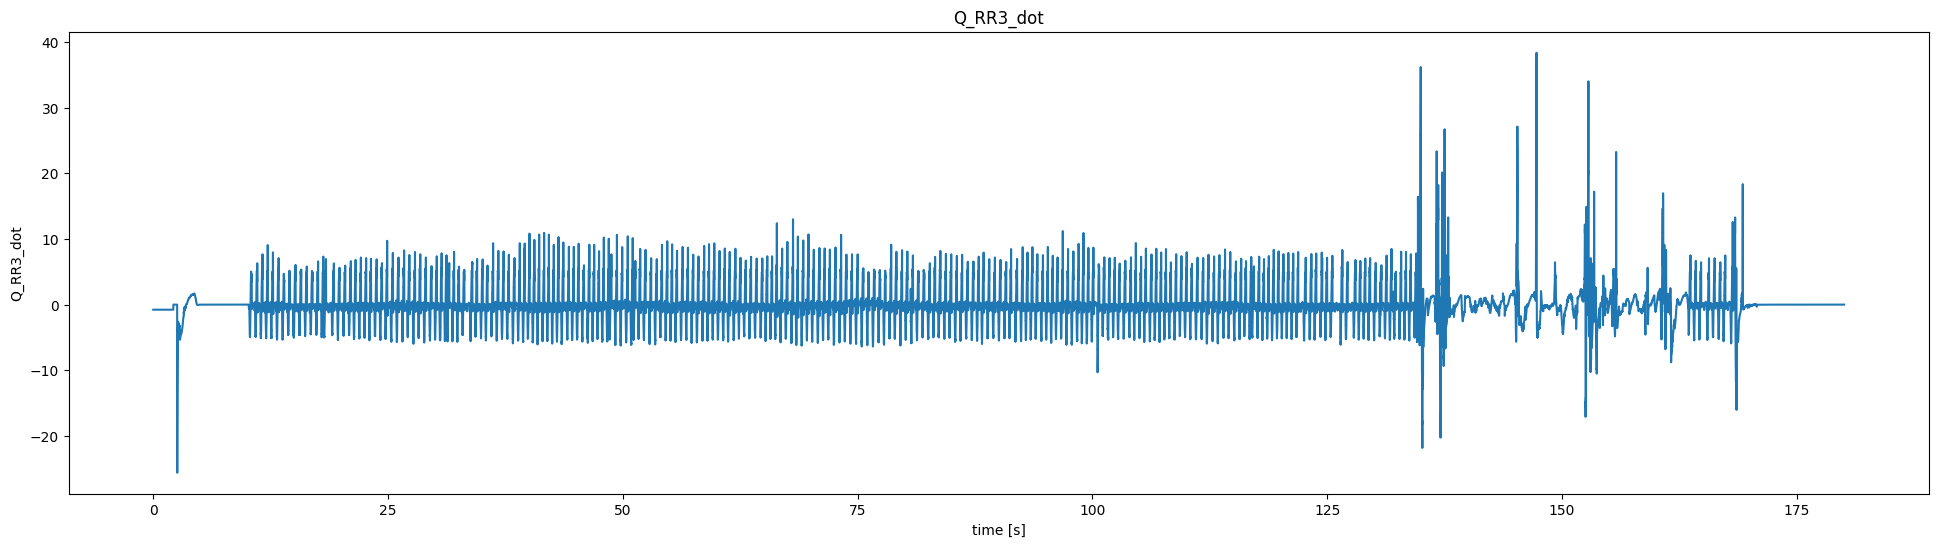

In [5]:
def PlotTimeserialData(time, data, name):
    plt.figure( figsize=[24, 6] )
    plt.ylabel( name )
    plt.title( name )
    plt.xlabel( "time [s]" )
    plt.plot( time, data )


for i in range(dim):
    PlotTimeserialData(time, q[:, i], q_name[i])
    PlotTimeserialData(time, qd[:, i], qd_name[i])


### Data processing

Number of timesteps in masked data: 175039
Shape of Rot Mtx arr: (175039, 3, 3)
1


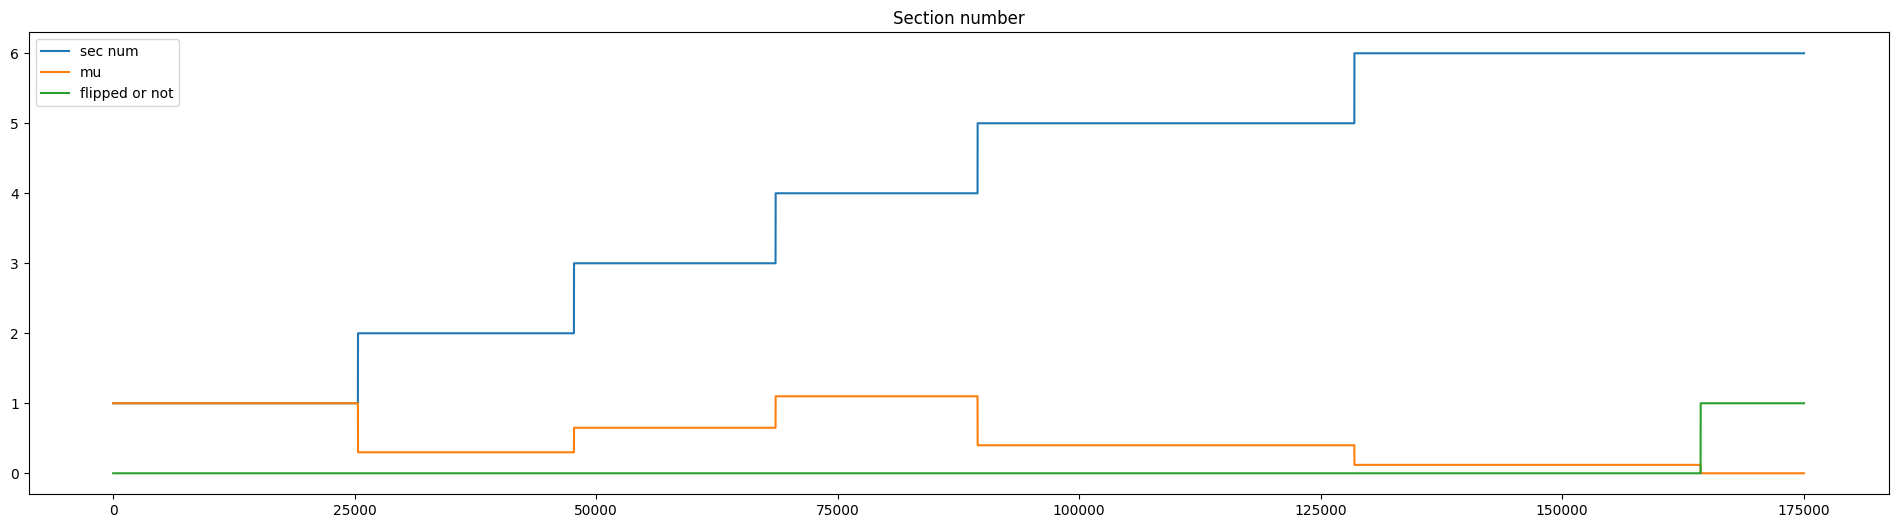

In [ ]:
# Data Processing (Eliminate trash data) + Labelling

def CurrentSector_valid(pos_glob, fric):  # Find the current sector number for Validation episode
    """
    pos_glob: current position of body link [X_global, Y_global] - dim = (timesteps, 2)
    return: the section number [1, 2, 3, 4, 5, 6] & mu
    """
    sec_num = 0
    if pos_glob[0] > -2 and pos_glob[0] < 2 :
        sec_num = 1
    elif pos_glob[0] >= 2 and pos_glob[0] < 6:
        sec_num = 2
    elif pos_glob[0] >= 6 and pos_glob[0] < 10:
        sec_num = 3
    elif pos_glob[0] >= 10 and pos_glob[0] < 14:
        sec_num = 4
    elif pos_glob[0] >= 14 and pos_glob[0] < 18:
        sec_num = 5
    elif pos_glob[0] >= 18 and pos_glob[0] < 22:
        sec_num = 6
    
    mu = fric[ sec_num-1 ]
    return sec_num, mu


# def SectionChange(pos_glob):  # Find the flag of Section Change
#     """
#     pos_glob: current position of body link [X_global, Y_global] - dim = (timesteps, 2)
#     return: ndarray that has flag info along time-series

#     If there's a abrupt change on global position, it's Section Change
#     """
#     sec_change = np.zeros( pos_glob.shape[0] )
#     for i in range(1, pos_glob.shape[0]):
#         x_diff = np.abs( pos_glob[i, 0] - pos_glob[i-1, 0] )
#         y_diff = np.abs( pos_glob[i, 1] - pos_glob[i-1, 1] )
#         if (x_diff > 10 or y_diff > 10):
#             sec_change[i] = 1
#     return sec_change


def Standardization(vel_body, Joint_pos, Joint_vel, ranges):
    # Z-standardization
    mean_q = np.array( [0.13648255,  1.02416556, -1.95959108, -0.14131353,  1.04013948, -1.95004023,
    0.14954833,  1.06459323, -1.96615373, -0.1464817,   1.06452196, -1.96095472] )
    std_q = np.array( [0.21421655,  0.32568444,  0.32402931,  0.1834761,   0.3377815,   0.32727451,
    0.10527512,  0.32064652,  0.33408471,  0.1218982,   0.32983543,  0.32722624] )
    std_qd = np.array( [0.90501806,   1.79143876,   2.34617924,   0.89090604,
    1.77888479,   2.36617882,   0.85101701,   1.74792794,   2.39545959,
    0.84295406,   1.76532283,   2.40336001] )
    std_vel_body = np.array( [  0.78711581,   1.42236275, 0.36703331] )

    vel_body_z = vel_body
    Joint_pos_z = Joint_pos
    Joint_vel_z = Joint_vel
    
    for i in range(3):
        vel_body_z[:, i] = vel_body_z[:, i] / std_vel_body[i]

    for i in range(12):
        Joint_pos_z[:, i] = ( Joint_vel_z[:, i] - mean_q[i] ) / std_q[i]
        Joint_vel_z[:, i] = Joint_vel_z[:, i] / std_qd[i]

    return vel_body_z, Joint_pos_z, Joint_vel_z


def Normalization(dat, max_abs):
    N = dat.shape[1]
    norm = np.zeros_like( dat )
    for i in range(N):
        norm[:, i] = ( dat[:, i] / max_abs[i] )
    return norm

##########


pos_glob = q[:, 0:2]  # Global position information
# print(pos_glob.shape[0])
friction = np.array( [1, 0.3, 0.65, 1.1, 0.4, 0.12] )  # validation

mask = np.ones_like(pos_glob[:, 0], dtype=bool)  # masking array to eliminate trash data
stand_period = 4000  # The peroid that robot was standing after section has been changed ( 4 sec )

for i in range( len(mask) ):
    if i <= 5000:
        mask[i] = False  # Set standing period to False

# Data that only contains Walking data !
q_masked = q[mask]
qd_masked = qd[mask]
N_t_masked = q_masked.shape[0]
print(f"Number of timesteps in masked data: {N_t_masked}")

R_gb = np.zeros( (N_t_masked, 3, 3) )
R_gb = R.from_euler('xyz', q_masked[:, 3:6]).as_matrix()
print(f"Shape of Rot Mtx arr: {R_gb.shape}")

vel_body = np.zeros( (N_t_masked, 6) )
vel_body_processed = np.zeros( (N_t_masked, 3) )
for i in range( N_t_masked ):
    vel_body[i, 0:3] = R_gb[i, :, :].T @ qd_masked[i, 0:3]   # Linear velocity
    vel_body[i, 3:6] = R_gb[i, :, :].T @ qd_masked[i, 3:6]   # Angular velocity

### 
vel_body_processed = vel_body[:, [0, 1, 5]]   # [ Vx_measured, Vy_measured, Vrz_measured ] in body frame
Joint_pos_processed = q_masked[:, 6:18]
Joint_vel_processed = qd_masked[:, 6:18]

# Normalize each data !
ranges = np.array( [[-1.0472, 1.0472], # Q_**1
                    [-1.5708, 3.4907], # Q_**2
                    [-2.7227, -0.83776], # Q_**3
                    ] )
vel_body_processed, Joint_pos_processed, Joint_vel_processed = Standardization(vel_body_processed, Joint_pos_processed, Joint_vel_processed, ranges)

max_abs_v_b = np.array( [15.57539624,  7.97206359, 34.17891475] )
max_abs_J_pos = np.array( [ 6.47085695,  7.45524046,  6.04757352,  7.07402294,  7.70482698,  5.95842371,
 11.78681689,  5.35219826,  5.88519526, 11.39731772,  5.5175986,  5.99265734] )
max_abs_J_vel = np.array( [33.5566882,  19.37785195, 40.90007895, 36.73593294, 17.80329403, 17.34517866,
 39.51680768, 17.83888331, 21.33566867, 34.15843528, 18.15686311, 21.47052995] )


Joint_pos_processed_log = np.sign(Joint_pos_processed) * np.log1p(np.abs(Joint_pos_processed))
Joint_vel_processed_log = np.sign(Joint_vel_processed) * np.log1p(np.abs(Joint_vel_processed))
Joint_pos_processed_tanh = np.tanh( Joint_pos_processed )
Joint_vel_processed_tanh = np.tanh( Joint_vel_processed )

# plt.figure( figsize=(24, 6) )
# plt.plot(vel_body_processed[:, 0])
# plt.title("Vx_body")
# plt.figure( figsize=(24, 6) )
# plt.plot(vel_body_processed[:, 1])
# plt.title("Vy_body")
# plt.figure( figsize=(24, 6) )
# plt.plot(vel_body_processed[:, 2])
# plt.title("Vrz_body")

# plt.figure( figsize=(24, 6) )
# plt.plot(Joint_pos_processed[:])
# plt.legend(["Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
# plt.title("Joint Pos")

# plt.figure( figsize=(24, 6) )
# plt.plot(Joint_pos_processed_log[:])
# plt.legend(["Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
# plt.title("Joint Pos_log1p")

# plt.figure( figsize=(24, 6) )
# plt.plot(Joint_pos_processed_tanh[:])
# plt.legend(["Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
# plt.title("Joint Pos_tanh")

# plt.figure( figsize=(24, 6) )
# plt.plot(Joint_vel_processed[:])
# plt.legend(["Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
# plt.title("Joint Vel")

# plt.figure( figsize=(24, 6) )
# plt.plot(Joint_vel_processed_log[:])
# plt.legend(["Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
# plt.title("Joint Vel_log1p")

# plt.figure( figsize=(24, 6) )
# plt.plot(Joint_vel_processed_tanh[:])
# plt.legend(["Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
# plt.title("Joint Vel_tanh")

section = np.zeros( N_t_masked )   # Store Current Section number

###  Find flip status
mu_flipped = 0  # Define the mu value when it is flipped
flip_flag = np.zeros(N_t_masked, dtype=bool)
for i in range(N_t_masked):
    if R_gb[i, 2, 2] < 0:   # When z-axis of body frame directs downward
        flip_flag[i] = 1
###

mu = np.zeros( N_t_masked )   # Store Current Section's firction coeffcient

for i in range( N_t_masked ):
    section[i], mu[i] = CurrentSector_valid( q_masked[i, 0:2], friction )
    if flip_flag[i] == 1:
        mu[i] = mu_flipped

plt.figure( figsize=(24, 6) )
plt.plot(section)
plt.plot(mu)
plt.plot(flip_flag)
plt.title("Section number")
plt.legend(["sec num", "mu", "flipped or not"])



# Now, let's split the data into each scene based on the flag
Processed_dataset = []

# Validation...
scene_BodyVel = vel_body_processed
scene_JointPos = Joint_pos_processed_log
scene_JointVel = Joint_vel_processed_log
scene_mu = mu
scene_combined = np.hstack([scene_BodyVel, scene_JointPos, scene_JointVel, scene_mu[:, np.newaxis]])
Processed_dataset.append(scene_combined)  # ( # of scenes, timesteps, variable dimensions )
print( len(Processed_dataset) )

In [ ]:
# #### Save data list as .pkl file (for fast loading)

# print( Processed_dataset[0].shape )

# # Save to pickle file
# with open("LOGSCALED_Valid1_20250322_155701_go2.pkl", "wb") as f:
#     pickle.dump(Processed_dataset, f)

(175039, 28)


### Construct DNN model
#### (  Set related params!  )

In [17]:
# Set model characteristics
structure = "FCNN"   # choose among - "FCNN", "LSTM", "Transformer"
horizon = 200  # the number of timesteps to include in feed-forward ( = size of DNN's input! )


# Set train params
activation = "Sigmoid"   # choose among - "Sigmoid", "ReLU", "ELU"
epoch = 300   # Number of epochs
lr = 0.001   # Learning rate
batch = 64   # Batch size


def ActFunc(act):
    if act == "ReLU":
        return nn.ReLU
    elif act == "ELU":
        return nn.ELU
    elif act == "Sigmoid":
        return nn.Sigmoid
    else:
        return "Wrong input"


# Random sampling & Generate DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, scene_list, horizon_size=200):
        """
        data: time-serial data (Numpy array)
        horizon_size: the number of continuous time steps
        """
        self.scene_list = scene_list
        self.horizon_size = horizon_size
        self.samples = []

        # Build index mapping for all samples across scenes
        for scene_idx, scene in enumerate(scene_list):
            max_start = len(scene) - horizon_size
            for i in range(max_start):
                self.samples.append((scene_idx, i))
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        scene_idx, start_idx = self.samples[idx]
        scene = self.scene_list[scene_idx]

        x = scene[start_idx:start_idx + self.horizon_size, 0:27]   # Input 
        y = scene[start_idx:start_idx + self.horizon_size, 27]   # Output
        
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

dataset = TimeSeriesDataset(Processed_dataset, horizon_size=horizon)
print(dataset)

dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, num_workers=4)

# DataLoader exploration
for batch_idx, (inputs, labels) in enumerate(dataloader):
    print(f'Batch {batch_idx + 1}: Input Size {inputs.shape}, Label Size {labels.shape}')

Batch 1: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 2: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 3: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 4: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 5: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 6: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 7: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 8: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 9: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 10: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 11: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 12: Input Size torch.Size([64, 200, 27]), Label Size torch.Size([64, 200])
Batch 13: Input Size torch.Size([64, 

In [ ]:
# ======================== Device Check ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("CUDA device count:", torch.cuda.device_count())
# =============================================================


##### Define DNN model class


# Define FCNN model class
class FCNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim=1, activation_fn=nn.ReLU):
        super(FCNN, self).__init__()

        self.flatten = nn.Flatten(start_dim=1)

        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation_fn())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))  # Output Layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.network(x)

# Model Train
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, Loss):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        Loss.append(running_loss/len(train_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.8f}")


# Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")




########################################## Hyper-parameter Set ##########################################


hidden_layers = [2048, 1024, 512, 256, 128, 64]  # hidden layer property


########################################## Hyper-parameter Set ##########################################


activation_fn = ActFunc(activation)
input_dim = horizon * 27
output_dim = 1

model = FCNN(input_dim, hidden_layers, output_dim, activation_fn).to(device)   # Initialize Model

criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr) # Optimizer


# test_dataset = 

train_loader = dataloader
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

loss = []

# Train & Evaluation
train_model(model, train_loader, criterion, optimizer, num_epochs=epoch, Loss=loss)
# evaluate_model(model, test_loader)

Current device: cuda
CUDA device name: NVIDIA GeForce RTX 4090
CUDA device count: 1


/home/hjang4/anaconda3/envs/Hanbin/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([64, 200])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/hjang4/anaconda3/envs/Hanbin/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([61, 200])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 0.067030
Epoch [2/50], Loss: 0.024957
Epoch [3/50], Loss: 0.022713
Epoch [4/50], Loss: 0.036938
Epoch [5/50], Loss: 0.012509
Epoch [6/50], Loss: 0.006954
Epoch [7/50], Loss: 0.005363
Epoch [8/50], Loss: 0.004042
Epoch [9/50], Loss: 0.003358
Epoch [10/50], Loss: 0.003121
Epoch [11/50], Loss: 0.005146
Epoch [12/50], Loss: 0.003864
Epoch [13/50], Loss: 0.003075
Epoch [14/50], Loss: 0.005288
Epoch [15/50], Loss: 0.005909
Epoch [16/50], Loss: 0.005079
Epoch [17/50], Loss: 0.002286
Epoch [18/50], Loss: 0.002244
Epoch [19/50], Loss: 0.001970
Epoch [20/50], Loss: 0.014691
Epoch [21/50], Loss: 0.003613
Epoch [22/50], Loss: 0.001964
Epoch [23/50], Loss: 0.001818
Epoch [24/50], Loss: 0.002972
Epoch [25/50], Loss: 0.003246
Epoch [26/50], Loss: 0.001794
Epoch [27/50], Loss: 0.001769
Epoch [28/50], Loss: 0.001710
Epoch [29/50], Loss: 0.001715
Epoch [30/50], Loss: 0.005045
Epoch [31/50], Loss: 0.002563
Epoch [32/50], Loss: 0.002207
Epoch [33/50], Loss: 0.004134
Epoch [34/50], Loss

In [207]:
model.eval()

with open('20250322_155701_go2.pkl', 'rb') as f:   # Validation Episode
    valid_data = pickle.load(f)

print(valid_data[0].dtype)

buff = np.zeros((valid_data[0].shape[0], 1))
print(buff.shape)

for i in range( len(buff) - horizon ):
    test = torch.tensor( valid_data[0][i:i+horizon, 0:27].flatten(), dtype=torch.float32).unsqueeze(0)
    test = test.to(device)
    with torch.no_grad():
        predictions = model(test)
    buff[i] = predictions.cpu().detach().numpy()

print("Outputs")
print(buff)

float64
(175040, 1)
Outputs
[[0.23516415]
 [0.23516415]
 [0.23516415]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


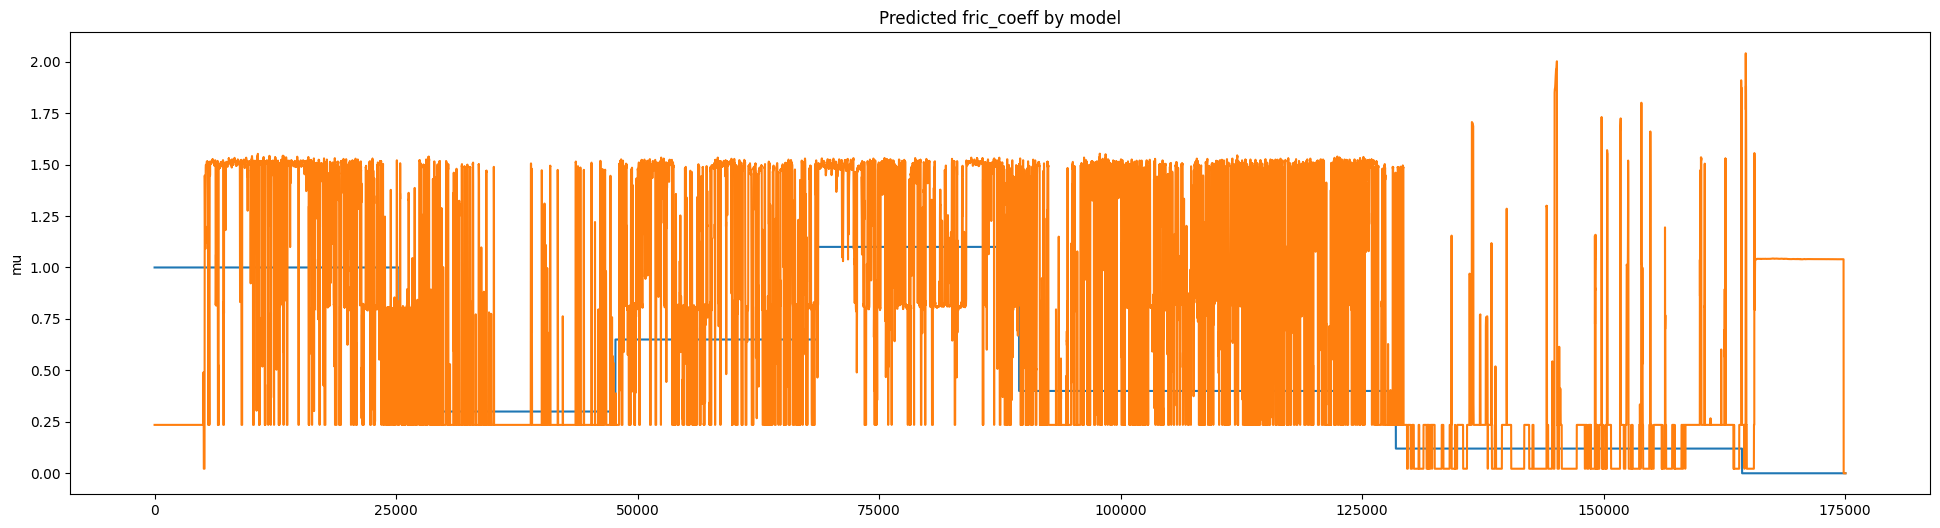

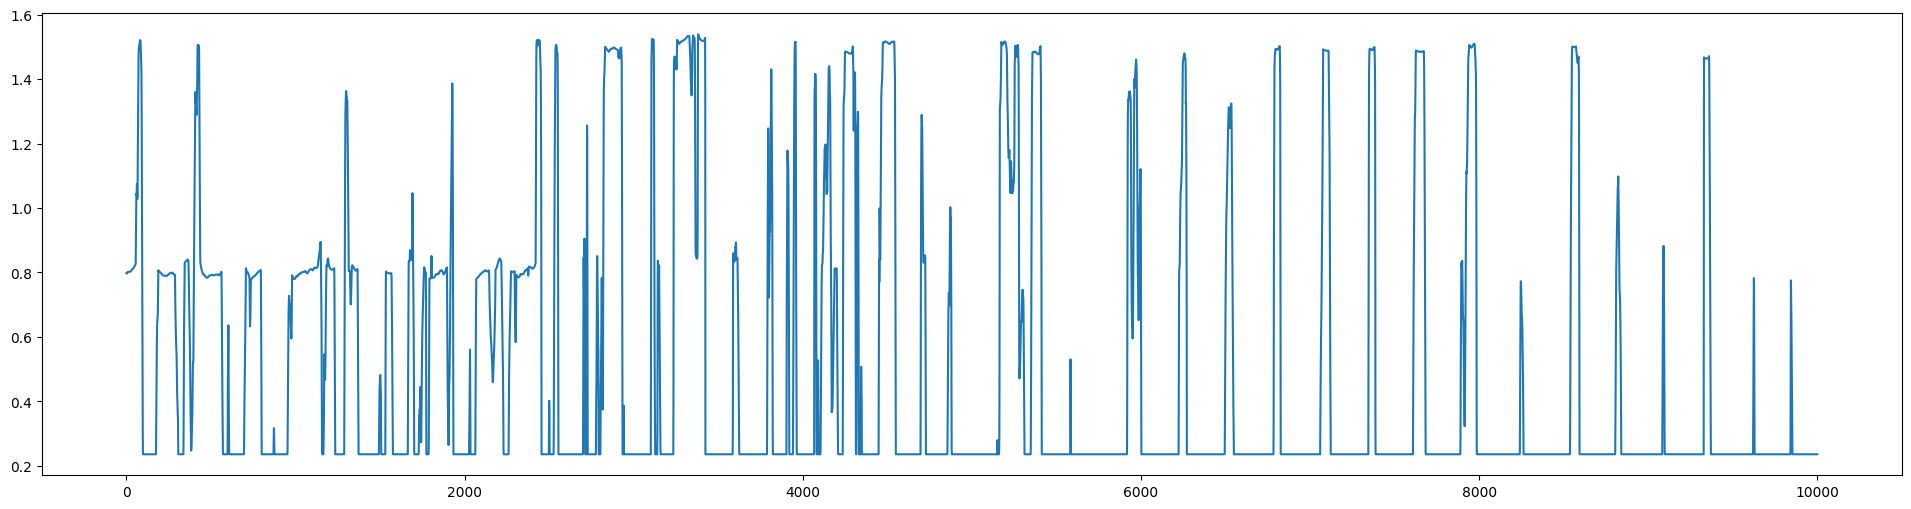

In [212]:
plt.figure( figsize=(24,6) )
plt.title("Predicted fric_coeff by model")
# plt.xlabel("time [s]")
plt.ylabel("mu")
# plt.plot( time[time_mask], buff )

plt.plot(valid_data[0][:, 27])
plt.plot(buff)

plt.figure( figsize=(24,6) )
plt.plot(buff[25000:35000])